# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 2](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition

This task aims to categorize the sexist messages according to the intention of the author in one of the following categories: (i) direct sexist message, (ii) reported sexist message and (iii) judgemental message.

### Examples:

#### DIRECT
The intention was to write a message that is sexist by itself or incites to be sexist, as in:

''*A woman needs love, to fill the fridge, if a man can give this to her in return for her services (housework, cooking, etc), I don’t see what else she needs.*''

#### REPORTED
The intention is to report and share a sexist situation suffered by a woman or women in first or third person, as in:

''*Today, one of my year 1 class pupils could not believe he’d lost a race against a girl.*''

#### JUDGEMENTAL
The intention was to judge, since the tweet describes sexist situations or behaviours with the aim of condemning them.

''*As usual, the woman was the one quitting her job for the family’s welfare…*''

## Setup and dependencies installation

In the following, we will assume that you have 
- created a local python virtual environment - either with python [venv](https://docs.python.org/3/library/venv.html) module or via [uv](https://github.com/astral-sh/uv) (preferred) - with the `ipykernel` or `jupyter` packages pre-installed to start the jupyter kernel;
- a stable internet connection
Nothing else is needed.

We will now download the `pyproject.toml` file specifying the project dependencies.

In [ ]:
import os
import urllib.request
from pathlib import Path


def get_project_root() -> Path:
    """Return the root directory of the project."""
    start_dir = Path.cwd()

    markers = ["assignment2.ipynb"]

    for path in [start_dir, *list(start_dir.parents)]:
        for marker in markers:
            if (path / marker).exists():
                return path

    return start_dir


project_root: Path = get_project_root()

In [ ]:
project_repo: str = "mpreda01/nlp-assignments"
project_branch: str = "main"
pyproject_url = (
    f"https://raw.githubusercontent.com/{project_repo}/{project_branch}/pyproject.toml"
)
lockfile_url = (
    f"https://raw.githubusercontent.com/{project_repo}/{project_branch}/uv.lock"
)
urllib.request.urlretrieve(pyproject_url, project_root / "pyproject.toml")  # noqa: S310
urllib.request.urlretrieve(lockfile_url, project_root / "uv.lock");  # noqa: S310

If using [uv](https://github.com/astral-sh/uv) (recommended) you can now install the dependencies to a local virtual environment at `.venv` simply via
```sh
uv sync --extra assignment1
```

If not, the same can be achieved with the usual python [venv](https://docs.python.org/3/library/venv.html):
```sh
python3 -m venv .venv
source .venv/bin/activate
(.venv) pip install ".[assignment1]" 
```

Make sure to do the above and *restart the kernel* if necessary before proceeding.

# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2025-2026/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.


### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 2**.
- For Task 2, labels are assigned by six annotators.
- The labels for Task 2 represent whether the tweet is non-sexist ('-') or its sexist intention ('DIRECT', 'REPORTED', 'JUDGEMENTAL').







### Example

```
    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }
```

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as ``pandas.DataFrame``.
3. **Aggregate labels** for Task 2 using majority voting and store them in a new dataframe column called `label`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `label`.
6. **Encode the `label` column**: Use the following mapping

```
{
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
```

In [ ]:
# File management
import os

# Utilities
import random

# NLP and Text Processing
import re
import shutil
import sys
import tarfile
import urllib
import urllib.request
import warnings
import zipfile
from collections import Counter
from pathlib import Path
from typing import Iterable

import evaluate

# Visualization and Analysis
import matplotlib.pyplot as plt
import nltk
import numpy as np

# Data manipulation
import pandas as pd

# Deep Learning - TensorFlow/Keras
import tensorflow as tf

# Deep Learning - PyTorch
import torch
import wandb
from datasets import Dataset
from huggingface_hub import HfApi, login, repo_exists, whoami
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.special import softmax
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize

# Machine Learning - Sklearn
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Transformers and HuggingFace
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertModel,
    BertTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

/Users/niccolozanotti/software/github.com/nlp-project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/niccolozanotti/software/github.com/nlp-project/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0=all, 1=info, 2=warning, 3=error

# Suppress TensorFlow logging
tf.get_logger().setLevel("ERROR")

In [ ]:
repo: str = "nlp-unibo/nlp-course-material"
branch: str = "main"
folder_path: str = "2025-2026/Assignment%201/data"
data_dir: Path = project_root / "data"
files = ["training.json", "test.json", "validation.json"]

base_url = f"https://raw.githubusercontent.com/{repo}/{branch}/{folder_path}"
data_dir.mkdir(exist_ok=True)

for filename in files:
    url = f"{base_url}/{filename}"
    destination = data_dir / f"{filename}"
    urllib.request.urlretrieve(url, destination)  # noqa: S310
    print(f"Saved to: {destination}")

Saved to: /Users/niccolozanotti/software/github.com/nlp-project/data/training.json
Saved to: /Users/niccolozanotti/software/github.com/nlp-project/data/test.json
Saved to: /Users/niccolozanotti/software/github.com/nlp-project/data/validation.json


In [ ]:
train = pd.read_json(data_dir / "training.json", orient="index")
val = pd.read_json(data_dir / "validation.json", orient="index")
test = pd.read_json(data_dir / "test.json", orient="index")

In [ ]:
def majority_vote(labels):
    """Apply majority voting to get the label with strict majority (>50%)"""
    if not isinstance(labels, list) or len(labels) == 0:
        return None
    top_label, freq = Counter(labels).most_common(1)[0]
    return top_label if freq > len(labels) / 2 else None

In [ ]:
# Label mapping for Task 2
label_map = {"-": 0, "DIRECT": 1, "JUDGEMENTAL": 2, "REPORTED": 3}

# Process train, validation, and test sets
for name in ("train", "val", "test"):
    df = globals()[name].copy()

    # Step 1: Aggregate labels using majority voting
    df["label"] = df["labels_task2"].apply(majority_vote)

    # Remove items without a clear majority
    df = df.dropna(subset=["label"])

    # Step 2: Filter to keep only English rows
    df = df[df["lang"] == "en"]

    # Step 3: Keep only required columns
    df = df[["id_EXIST", "lang", "tweet", "label"]]

    # Step 4: Encode the label column
    df["label"] = df["label"].map(label_map)

    # Update the global variable
    globals()[name] = df.reset_index(drop=True)

print(f"Train set shape: {train.shape}")
print(f"Validation set shape: {val.shape}")
print(f"Test set shape: {test.shape}")
print(
    f"\nLabel distribution in train set:\n{train['label'].value_counts().sort_index()}"
)
train.head()

Train set shape: (2202, 4)
Validation set shape: (115, 4)
Test set shape: (217, 4)

Label distribution in train set:
label
0    1733
1     336
2      42
3      91
Name: count, dtype: int64


,id_EXIST,lang,tweet,label
0,200002,en,Writing a uni essay in my local pub with a cof...,3
1,200006,en,According to a customer I have plenty of time ...,3
2,200008,en,New to the shelves this week - looking forward...,0
3,200010,en,I guess that’s fairly normal for a Neanderthal...,0
4,200011,en,#EverydaySexism means women usually end up in ...,2


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [ ]:
# Download required NLTK data
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("averaged_perceptron_tagger_eng", quiet=True)

lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet POS tags for better lemmatization"""
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN  # Default to noun


def clean_tweet(text):
    """Clean tweet text by removing noise and performing lemmatization"""
    if not isinstance(text, str):
        return text

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove mentions (@user)
    text = re.sub(r"@\w+", "", text)

    # Remove hashtags (#example)
    text = re.sub(r"#\w+", "", text)

    # Remove emojis
    text = re.sub(r"[^\w\s\-\.\,\!\?\']", "", text)

    # Remove specific quote characters (curly quotes, etc.)
    text = re.sub(r'[""' "`´]", '"', text)  # noqa: RUF001

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove special characters and short tokens, then lemmatize
    cleaned_tokens = []
    pos_tags = nltk.pos_tag(tokens)

    for token, pos in pos_tags:
        # Skip if token is too short or only special characters
        if len(token) < 2:  # noqa: PLR2004
            continue
        # Lemmatize using POS tag
        wordnet_pos = get_wordnet_pos(pos)
        lemmatized = lemmatizer.lemmatize(token, pos=wordnet_pos)
        cleaned_tokens.append(lemmatized)

    return " ".join(cleaned_tokens)


# Apply cleaning to all datasets
for name in ("train", "val", "test"):
    print(f"Cleaning {name} set...")
    globals()[name]["tweet"] = globals()[name]["tweet"].apply(clean_tweet)

print("\nData cleaning completed!")
print(f"\nSample cleaned tweets from train set:")
for i in range(min(3, len(train))):
    print(f"{i + 1}. {train['tweet'].iloc[i][:100]}...")

Cleaning train set...
Cleaning val set...
Cleaning test set...

Data cleaning completed!

Sample cleaned tweets from train set:
1. write uni essay in my local pub with coffee random old man keep ask me drunk question when 'm try to...
2. accord to customer have plenty of time to go spent the stirling coin he want to pay me with in derry...
3. new to the shelf this week look forward to read these book...


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., ``<UNK>``) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [ ]:
# GloVe embedding dimension
EMBEDDING_DIM = 100

# Create embeddings directory
embeddings_dir: Path = project_root / "embeddings"
if not os.path.exists(embeddings_dir):
    embeddings_dir.mkdir()

# Download GloVe embeddings (6B tokens, 100d)
glove_file = embeddings_dir / f"glove.6B.{EMBEDDING_DIM}d.txt"

if not os.path.exists(glove_file):
    print("Downloading GloVe embeddings...")
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    zip_path = embeddings_dir / "glove.6B.zip"
    urllib.request.urlretrieve(url, zip_path)  # noqa: S310

    print("Extracting embeddings...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(embeddings_dir)  # noqa: S202
    os.remove(zip_path)
    print("Done!")

# Load GloVe embeddings into a dictionary
print(f"Loading GloVe embeddings ({EMBEDDING_DIM}d)...")
glove_embeddings = {}
with open(glove_file, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype="float32")
        glove_embeddings[word] = vector

print(f"Loaded {len(glove_embeddings)} word embeddings from GloVe")

# Build vocabulary from training set
print("\nBuilding vocabulary...")
vocab = {}
vocab_idx = 0

# Special tokens
vocab["<PAD>"] = vocab_idx
vocab_idx += 1
vocab["<UNK>"] = vocab_idx
vocab_idx += 1

# Collect all unique tokens from training data
train_tokens = set()
for tweet in train["tweet"]:
    tokens = tweet.split()
    train_tokens.update(tokens)

print(f"Tokens in training set: {len(train_tokens)}")

# First, add all training tokens to vocabulary
for token in sorted(train_tokens):
    if token not in vocab:
        vocab[token] = vocab_idx
        vocab_idx += 1

# Optionally add GloVe tokens not in training (union approach)
# This enriches our vocabulary with words that might appear in val/test
glove_tokens_added = 0
# Sample 10% of GloVe tokens not in training to keep vocabulary manageable
glove_sample = np.random.choice(  # noqa: NPY002
    list(set(glove_embeddings.keys()) - train_tokens),
    size=min(50000, len(glove_embeddings) // 10),
    replace=False,
)
for token in sorted(glove_sample):
    if token not in vocab:
        vocab[token] = vocab_idx
        vocab_idx += 1
        glove_tokens_added += 1

print(f"Vocabulary size: {len(vocab)}")
print(f"  - Training tokens: {len(train_tokens)}")
print(f"  - GloVe tokens added: {glove_tokens_added}")

# Create embedding matrix
print("\nCreating embedding matrix...")
embedding_matrix = np.zeros((len(vocab), EMBEDDING_DIM))

# Initialize embeddings
oov_count = 0
glove_count = 0

for token, idx in vocab.items():
    if token in glove_embeddings:
        # Token found in GloVe - use pre-trained embedding
        embedding_matrix[idx] = glove_embeddings[token]
        glove_count += 1
    elif token == "<PAD>":  # noqa: S105
        # PAD token gets zero vector (will be masked)
        embedding_matrix[idx] = np.zeros(EMBEDDING_DIM)
    elif token == "<UNK>":  # noqa: S105
        # UNK token gets random initialization
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=EMBEDDING_DIM)  # noqa: NPY002
    else:
        # OOV tokens in training set get random initialization
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=EMBEDDING_DIM)  # noqa: NPY002
        oov_count += 1

print(f"Embeddings from GloVe: {glove_count}")
print(f"Custom embeddings (OOV training tokens): {oov_count}")
print(f"Embedding matrix shape: {embedding_matrix.shape}")

# Create reverse vocabulary (index to token)
idx_to_vocab = {v: k for k, v in vocab.items()}


# Function to encode tweets for validation and test sets
def encode_tweet(tweet, vocab):
    """
    Encode a tweet to token indices.

    Strategy for tokens:
    - If token in vocabulary: use its index
    - If token NOT in vocabulary (OOV in val/test): map to <UNK> token

    This ensures all val/test tokens get an embedding (either their own or <UNK>)
    """
    tokens = tweet.split()
    indices = []
    for token in tokens:
        if token in vocab:
            indices.append(vocab[token])
        else:
            # Token not in vocabulary -> map to <UNK>
            indices.append(vocab["<UNK>"])
    return indices


# Encode validation and test sets using the token-to-index mapping
print("\nEncoding datasets...")
train["encoded_tweet"] = train["tweet"].apply(lambda x: encode_tweet(x, vocab))
val["encoded_tweet"] = val["tweet"].apply(lambda x: encode_tweet(x, vocab))
test["encoded_tweet"] = test["tweet"].apply(lambda x: encode_tweet(x, vocab))

print("Datasets encoded successfully!")


print("\nVocabulary Coverage:")
print(f"  - Vocabulary size: {len(vocab)}")
print(f"  - GloVe coverage: {glove_count / len(vocab) * 100:.1f}%")
print(f"  - Custom coverage: {oov_count / len(vocab) * 100:.1f}%")
print("=" * 70)

print("\nExample vocab and embeddings:")
for token in ["the", "woman", "sexist", "<UNK>", "<PAD>"]:
    if token in vocab:
        idx = vocab[token]
        print(f"  {token}: index={idx}, embedding_dim={embedding_matrix[idx].shape[0]}")

Extracting embeddings...
Done!
Loading GloVe embeddings (100d)...
Loaded 400000 word embeddings from GloVe

Building vocabulary...
Tokens in training set: 8362
Vocabulary size: 48364
  - Training tokens: 8362
  - GloVe tokens added: 40000

Creating embedding matrix...
Embeddings from GloVe: 47056
Custom embeddings (OOV training tokens): 1306
Embedding matrix shape: (48364, 100)

Encoding datasets...
Datasets encoded successfully!

Vocabulary Coverage:
  - Vocabulary size: 48364
  - GloVe coverage: 97.3%
  - Custom coverage: 2.7%

Example vocab and embeddings:
  the: index=7362, embedding_dim=100
  woman: index=8170, embedding_dim=100
  sexist: index=6582, embedding_dim=100
  <UNK>: index=1, embedding_dim=100
  <PAD>: index=0, embedding_dim=100


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.

* **Stacked**: add an additional Bidirectional LSTM layer to the Baseline model.

**Note**: You are **free** to experiment with hyper-parameters.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape ``(batch_size, # tokens, embedding_dim)`` to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [ ]:
# Hyperparameters
MAX_SEQ_LENGTH = 100
LSTM_UNITS = 64
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001
NUM_CLASSES = 4  # 0: non-sexist, 1: direct, 2: judgemental, 3: reported

In [ ]:
# Pad sequences to the same length
print("Padding sequences...")
train_padded = pad_sequences(
    train["encoded_tweet"], maxlen=MAX_SEQ_LENGTH, padding="post"
)
val_padded = pad_sequences(val["encoded_tweet"], maxlen=MAX_SEQ_LENGTH, padding="post")
test_padded = pad_sequences(
    test["encoded_tweet"], maxlen=MAX_SEQ_LENGTH, padding="post"
)

print(f"Padded sequences shape: {train_padded.shape}")

# Prepare labels
y_train = train["label"].values
y_val = val["label"].values
y_test = test["label"].values

print(f"Train labels shape: {y_train.shape}")
print(f"Val labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")


# Function to create Baseline model
def create_baseline_model(  # noqa: PLR0913
    vocab_size,
    embedding_dim,
    max_seq_length,  # noqa: ARG001
    embedding_matrix,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
):
    """
    Create Baseline model: Embedding -> Bidirectional LSTM -> Dense

    Args:
        vocab_size: Size of vocabulary
        embedding_dim: Embedding dimension
        max_seq_length: Maximum sequence length
        embedding_matrix: Pre-trained embedding matrix
        lstm_units: Number of LSTM units
        dropout_rate: Dropout rate
        num_classes: Number of output classes
        learning_rate: Learning rate for optimizer

    Returns:
        Compiled model
    """
    model = Sequential(
        [
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                trainable=False,  # Keep GloVe embeddings frozen
                name="embedding",
            ),
            Bidirectional(
                LSTM(units=lstm_units, return_sequences=False), name="bilstm_1"
            ),
            Dropout(dropout_rate),
            Dense(units=num_classes, activation="softmax", name="output"),
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Function to create Stacked model
def create_stacked_model(  # noqa: PLR0913
    vocab_size,
    embedding_dim,
    max_seq_length,  # noqa: ARG001
    embedding_matrix,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
):
    """
    Create Stacked model: Embedding -> BiLSTM -> BiLSTM -> Dense

    Args:
        vocab_size: Size of vocabulary
        embedding_dim: Embedding dimension
        max_seq_length: Maximum sequence length
        embedding_matrix: Pre-trained embedding matrix
        lstm_units: Number of LSTM units per layer
        dropout_rate: Dropout rate
        num_classes: Number of output classes
        learning_rate: Learning rate for optimizer

    Returns:
        Compiled model
    """
    model = Sequential(
        [
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                trainable=False,  # Keep GloVe embeddings frozen
                name="embedding",
            ),
            Bidirectional(
                LSTM(units=lstm_units, return_sequences=True), name="bilstm_1"
            ),
            Dropout(dropout_rate),
            Bidirectional(
                LSTM(units=lstm_units, return_sequences=False), name="bilstm_2"
            ),
            Dropout(dropout_rate),
            Dense(units=num_classes, activation="softmax", name="output"),
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Create models
print("\n" + "=" * 70)
print("MODEL CREATION")
print("=" * 70)

baseline_model = create_baseline_model(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    max_seq_length=MAX_SEQ_LENGTH,
    embedding_matrix=embedding_matrix,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
)

stacked_model = create_stacked_model(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    max_seq_length=MAX_SEQ_LENGTH,
    embedding_matrix=embedding_matrix,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
)

print("\nBASELINE MODEL ARCHITECTURE:")
baseline_model.summary()

print("\n" + "=" * 70)
print("\nSTACKED MODEL ARCHITECTURE:")
stacked_model.summary()

# Configuration summary
print("\n" + "=" * 70)
print("HYPERPARAMETER CONFIGURATION")
print("=" * 70)
print(f"Max Sequence Length: {MAX_SEQ_LENGTH}")
print(f"Embedding Dimension: {EMBEDDING_DIM}")
print(f"LSTM Units: {LSTM_UNITS}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Vocabulary Size: {len(vocab)}")
print("=" * 70)

Padding sequences...
Padded sequences shape: (2202, 100)
Train labels shape: (2202,)
Val labels shape: (115,)
Test labels shape: (217,)

MODEL CREATION

BASELINE MODEL ARCHITECTURE:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     4,836,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,836,400 (18.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,836,400 (18.45 MB)



STACKED MODEL ARCHITECTURE:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     4,836,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_2 (Bidirectional)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,836,400 (18.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,836,400 (18.45 MB)


HYPERPARAMETER CONFIGURATION
Max Sequence Length: 100
Embedding Dimension: 100
LSTM Units: 64
Dropout Rate: 0.3
Learning Rate: 0.001
Number of Classes: 4
Vocabulary Size: 48364


# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Stacked models.



### Instructions

* Pick **at least** three seeds for robust estimation.
* Train **all** models on the train set.
* Evaluate **all** models on the validation and test sets.
* Compute macro F1-score, precision, and recall metrics on the validation set.
* Report average and standard deviation measures over seeds for each metric.
* Pick the **best** performing model according to the observed validation set performance (use macro F1-score).

In [ ]:
os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_DETERMINISTIC_OPS"] = "1"

tf.config.experimental.enable_op_determinism()


def set_seeds(seed):
    """Set random seeds for reproducibility"""
    # Python
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # NumPy
    np.random.seed(seed)  # noqa: NPY002

    # TensorFlow - both global and operation level
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)  # Additional TF seeding

In [ ]:
f1_metric = evaluate.load("f1")
pre_metric = evaluate.load("precision")
rec_metric = evaluate.load("recall")
acc_metric = evaluate.load("accuracy")


def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    acc = acc_metric.compute(predictions=predictions, references=labels)

    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    pre = pre_metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    rec = rec_metric.compute(
        predictions=predictions, references=labels, average="macro"
    )

    return {**acc, **f1, **pre, **rec}

In [ ]:
SEEDS = [42, 53, 82]
EPOCHS = 50
BATCH_SIZE = 512

In [ ]:
models = {}
training_histories = {}  # Store training histories for plotting

for seed in SEEDS:
    print("\n" + "=" * 70)
    print(f"TRAINING WITH SEED: {seed}")
    print("=" * 70)

    # Set seeds for reproducibility
    set_seeds(seed)

    models[seed] = {}
    training_histories[seed] = {}

    # Re-create models for each seed
    models[seed]["baseline_model"] = create_baseline_model(
        vocab_size=len(vocab),
        embedding_dim=EMBEDDING_DIM,
        max_seq_length=MAX_SEQ_LENGTH,
        embedding_matrix=embedding_matrix,
        lstm_units=LSTM_UNITS,
        dropout_rate=DROPOUT_RATE,
        num_classes=NUM_CLASSES,
        learning_rate=LEARNING_RATE,
    )

    models[seed]["stacked_model"] = create_stacked_model(
        vocab_size=len(vocab),
        embedding_dim=EMBEDDING_DIM,
        max_seq_length=MAX_SEQ_LENGTH,
        embedding_matrix=embedding_matrix,
        lstm_units=LSTM_UNITS,
        dropout_rate=DROPOUT_RATE,
        num_classes=NUM_CLASSES,
        learning_rate=LEARNING_RATE,
    )

    # Train Baseline model
    print("\nTraining Baseline Model...")
    training_histories[seed]["baseline"] = models[seed]["baseline_model"].fit(
        train_padded,
        y_train,
        validation_data=(val_padded, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
    )

    # Train Stacked model
    print("\nTraining Stacked Model...")
    training_histories[seed]["stacked"] = models[seed]["stacked_model"].fit(
        train_padded,
        y_train,
        validation_data=(val_padded, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
    )


TRAINING WITH SEED: 42

Training Baseline Model...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.5536 - loss: 1.2377 - val_accuracy: 0.7826 - val_loss: 0.9306
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7791 - loss: 0.8506 - val_accuracy: 0.7826 - val_loss: 0.7960
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7813 - loss: 0.7598 - val_accuracy: 0.7826 - val_loss: 0.7969
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7821 - loss: 0.7388 - val_accuracy: 0.7826 - val_loss: 0.7857
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7821 - loss: 0.7118 - val_accuracy: 0.7826 - val_loss: 0.7912
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7816 - loss: 0.7006 - val_accuracy: 0.7826 - val_loss: 0.7869
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7821 - loss: 0.6977 - val_accuracy: 0.7826 - val_loss: 0.7837
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7819 - l

In [ ]:
# Compute metrics on validation set for each model and seed
val_metrics = {}
val_metrics = {"baseline_model": {}, "stacked_model": {}}

for seed in SEEDS:
    # Baseline Model Validation Metrics
    val_metrics["baseline_model"][seed] = {}

    baseline_pred = models[seed]["baseline_model"].predict(val_padded, verbose=0)
    val_metrics["baseline_model"][seed] = compute_metrics((baseline_pred, y_val))

    # Stacked Model Validation Metrics
    val_metrics["stacked_model"][seed] = {}

    stacked_pred = models[seed]["stacked_model"].predict(val_padded, verbose=0)
    val_metrics["stacked_model"][seed] = compute_metrics((stacked_pred, y_val))

# Compute average and std dev across seeds
print("\n" + "=" * 70)
print("AVERAGE METRICS ACROSS SEEDS")
print("=" * 70)

baseline_f1_scores = [val_metrics["baseline_model"][seed]["f1"] for seed in SEEDS]
baseline_precision_scores = [
    val_metrics["baseline_model"][seed]["precision"] for seed in SEEDS
]
baseline_recall_scores = [
    val_metrics["baseline_model"][seed]["recall"] for seed in SEEDS
]

stacked_f1_scores = [val_metrics["stacked_model"][seed]["f1"] for seed in SEEDS]
stacked_precision_scores = [
    val_metrics["stacked_model"][seed]["precision"] for seed in SEEDS
]
stacked_recall_scores = [val_metrics["stacked_model"][seed]["recall"] for seed in SEEDS]

print("\nBaseline Model:")
print(
    f"  F1-Score (macro):     {np.mean(baseline_f1_scores):.4f} ± {np.std(baseline_f1_scores):.4f}"  # noqa: E501
)
print(
    f"  Precision (macro):    {np.mean(baseline_precision_scores):.4f} ± {np.std(baseline_precision_scores):.4f}"  # noqa: E501
)
print(
    f"  Recall (macro):       {np.mean(baseline_recall_scores):.4f} ± {np.std(baseline_recall_scores):.4f}"  # noqa: E501
)

print("\nStacked Model:")
print(
    f"  F1-Score (macro):     {np.mean(stacked_f1_scores):.4f} ± {np.std(stacked_f1_scores):.4f}"  # noqa: E501
)
print(
    f"  Precision (macro):    {np.mean(stacked_precision_scores):.4f} ± {np.std(stacked_precision_scores):.4f}"  # noqa: E501
)
print(
    f"  Recall (macro):       {np.mean(stacked_recall_scores):.4f} ± {np.std(stacked_recall_scores):.4f}"  # noqa: E501
)

# Determine best model
best_baseline_f1 = np.max(baseline_f1_scores)
best_stacked_f1 = np.max(stacked_f1_scores)
best_model_type = "Baseline" if best_baseline_f1 >= best_stacked_f1 else "Stacked"
best_f1_score = max(best_baseline_f1, best_stacked_f1)

print("\n" + "=" * 70)
print(f"BEST MODEL: {best_model_type} (Macro F1-Score: {best_f1_score:.4f})")
print("=" * 70)


AVERAGE METRICS ACROSS SEEDS

Baseline Model:
  F1-Score (macro):     0.3864 ± 0.0176
  Precision (macro):    0.4133 ± 0.0156
  Recall (macro):       0.3788 ± 0.0209

Stacked Model:
  F1-Score (macro):     0.3050 ± 0.0486
  Precision (macro):    0.3830 ± 0.1194
  Recall (macro):       0.2991 ± 0.0308

BEST MODEL: Baseline (Macro F1-Score: 0.4062)


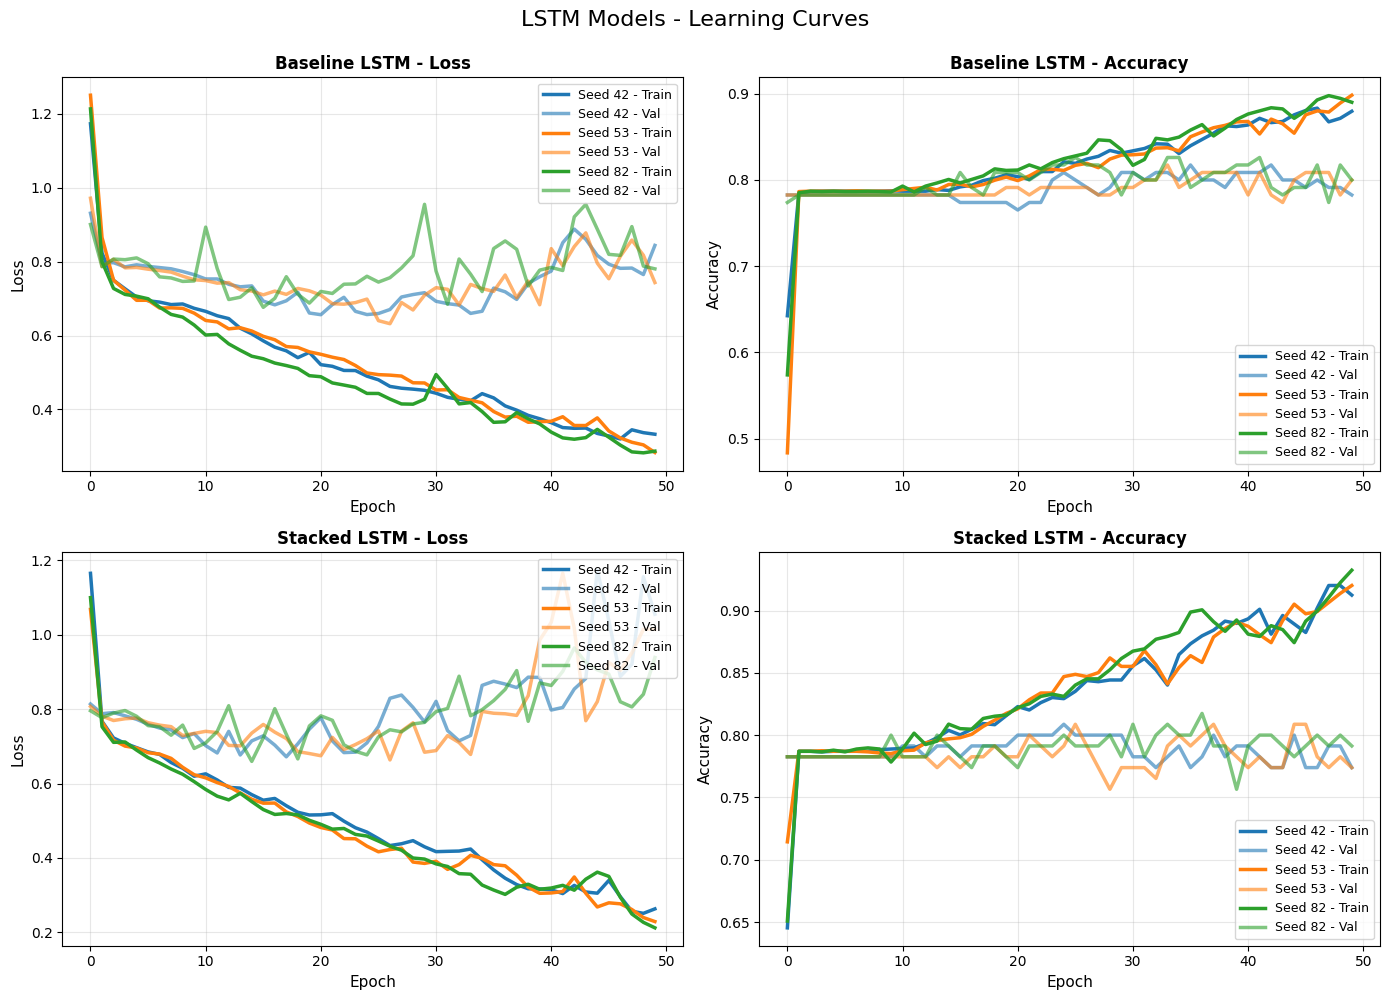

In [ ]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Create figure with 4 subplots: Baseline Loss, Baseline Acc, Stacked Loss, Stacked Acc
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("LSTM Models - Learning Curves", fontsize=16, y=0.995)

# BASELINE LOSS - All seeds overlaid
for seed_idx, seed in enumerate(SEEDS):
    history = training_histories[seed]["baseline"]
    axes[0, 0].plot(
        history.history["loss"],
        label=f"Seed {seed} - Train",
        linewidth=2.5,
        color=colors[seed_idx],
    )
    axes[0, 0].plot(
        history.history["val_loss"],
        label=f"Seed {seed} - Val",
        linewidth=2.5,
        color=colors[seed_idx],
        alpha=0.6,
    )

axes[0, 0].set_xlabel("Epoch", fontsize=11)
axes[0, 0].set_ylabel("Loss", fontsize=11)
axes[0, 0].set_title("Baseline LSTM - Loss", fontsize=12, fontweight="bold")
axes[0, 0].legend(fontsize=9, loc="upper right")
axes[0, 0].grid(True, alpha=0.3)

# BASELINE ACCURACY - All seeds overlaid
for seed_idx, seed in enumerate(SEEDS):
    history = training_histories[seed]["baseline"]
    axes[0, 1].plot(
        history.history["accuracy"],
        label=f"Seed {seed} - Train",
        linewidth=2.5,
        color=colors[seed_idx],
    )
    axes[0, 1].plot(
        history.history["val_accuracy"],
        label=f"Seed {seed} - Val",
        linewidth=2.5,
        color=colors[seed_idx],
        alpha=0.6,
    )

axes[0, 1].set_xlabel("Epoch", fontsize=11)
axes[0, 1].set_ylabel("Accuracy", fontsize=11)
axes[0, 1].set_title("Baseline LSTM - Accuracy", fontsize=12, fontweight="bold")
axes[0, 1].legend(fontsize=9, loc="lower right")
axes[0, 1].grid(True, alpha=0.3)

# STACKED LOSS - All seeds overlaid
for seed_idx, seed in enumerate(SEEDS):
    history = training_histories[seed]["stacked"]
    axes[1, 0].plot(
        history.history["loss"],
        label=f"Seed {seed} - Train",
        linewidth=2.5,
        color=colors[seed_idx],
    )
    axes[1, 0].plot(
        history.history["val_loss"],
        label=f"Seed {seed} - Val",
        linewidth=2.5,
        color=colors[seed_idx],
        alpha=0.6,
    )

axes[1, 0].set_xlabel("Epoch", fontsize=11)
axes[1, 0].set_ylabel("Loss", fontsize=11)
axes[1, 0].set_title("Stacked LSTM - Loss", fontsize=12, fontweight="bold")
axes[1, 0].legend(fontsize=9, loc="upper right")
axes[1, 0].grid(True, alpha=0.3)

# STACKED ACCURACY - All seeds overlaid
for seed_idx, seed in enumerate(SEEDS):
    history = training_histories[seed]["stacked"]
    axes[1, 1].plot(
        history.history["accuracy"],
        label=f"Seed {seed} - Train",
        linewidth=2.5,
        color=colors[seed_idx],
    )
    axes[1, 1].plot(
        history.history["val_accuracy"],
        label=f"Seed {seed} - Val",
        linewidth=2.5,
        color=colors[seed_idx],
        alpha=0.6,
    )

axes[1, 1].set_xlabel("Epoch", fontsize=11)
axes[1, 1].set_ylabel("Accuracy", fontsize=11)
axes[1, 1].set_title("Stacked LSTM - Accuracy", fontsize=12, fontweight="bold")
axes[1, 1].legend(fontsize=9, loc="lower right")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
- **Load the Tokenizer and Model**

- **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

- **Train the Model**:
   Use the `Trainer` to train the model on your training data.

- **Evaluate the Model on the Test Set** using the same metrics used for LSTM-based models.

Once we have created an account and an access token, we need to login to Huggingface via code. Add an environment variable `HF_TOKEN` with your token
```sh
export HF_TOKEN="my-huggingface-token-with-the-correct-access-rights"
```
as [expected by huggingface](https://huggingface.co/docs/huggingface_hub/package_reference/environment_variables#hftoken).


In [ ]:
hf_token = os.environ.get("HF_TOKEN")

if hf_token:
    try:
        login(token=hf_token, add_to_git_credential=True)
        user = whoami(token=hf_token)
        username = user["name"]
        print(f"Logged in as @{username}")
        print(f"Profile page: https://huggingface.co/{username}")
    except ValueError:
        print("Invalid token.")
    except ImportError:
        print("ipywidgets not installed.")
else:
    print("Warning: 'HF_TOKEN' environment variable not set.")

In [ ]:
api = HfApi()
repo_id = "nlp-transformer-weights"

# Check if repo already exists
if repo_exists(repo_id):
    print(f"Repository '{repo_id}' already exists")
else:
    print(f"Creating repository '{repo_id}'...")
    api.create_repo(repo_id=repo_id)
    print(f"Repository created successfully")

# Tokenization

In [ ]:
task = "hate"
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Tokenize the datasets
encoded_train_raw = tokenizer(train["tweet"].tolist(), padding=True)
encoded_val_raw = tokenizer(val["tweet"].tolist(), padding=True)
encoded_test_raw = tokenizer(test["tweet"].tolist(), padding=True)

# Convert to Hugging Face Dataset objects
encoded_train = Dataset.from_dict(encoded_train_raw)
encoded_val = Dataset.from_dict(encoded_val_raw)
encoded_test = Dataset.from_dict(encoded_test_raw)

# Add labels to the datasets
encoded_train = encoded_train.add_column("labels", train["label"].tolist())
encoded_val = encoded_val.add_column("labels", val["label"].tolist())
encoded_test = encoded_test.add_column("labels", test["label"].tolist())

In [ ]:
original_text = train["tweet"][12]
decoded_text = tokenizer.decode(encoded_train["input_ids"][12])

print(original_text[:200])
print()
print()
print(decoded_text[:200])

it 's especially weird because the alt-right on youtube be old than breadtube which be reaction to rw gamergate content


<s>it 's especially weird because the alt-right on youtube be old than breadtube which be reaction to rw gamergate content</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad


# Class weighting

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    "balanced", classes=np.unique(train["label"].tolist()), y=train["label"].tolist()
)
class_weights = torch.tensor(class_weights, dtype=torch.float)


# Custom Trainer
class WeightedLossTrainer(Trainer):
    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        num_items_in_batch=None,  # noqa: ARG002
    ):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Move class_weights to the same device as labels
        loss_fct = CrossEntropyLoss(weight=class_weights.to(labels.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


os.environ["WANDB_PROJECT"] = "nlp_assignment"  # name your W&B project
os.environ["WANDB_LOG_MODEL"] = "false"  # dont log all model checkpoints

# Ablation study for transformer model 

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("=" * 70)
print("TRAINING 4 TRANSFORMER MODEL VARIANTS")
print("=" * 70)

# Dictionary to store all trained models
transformer_models = {}

# ============================================================================
# MODEL 1: STANDARD MODEL WITH DEFAULT SETTINGS (10 EPOCHS)
# ============================================================================
print("\n" + "=" * 70)
print("MODEL 1: STANDARD TRANSFORMER (10 EPOCHS, DEFAULT)")
print("=" * 70)

# Create model
model_1 = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=NUM_CLASSES,
    id2label={0: "-", 1: "DIRECT", 2: "JUDGEMENTAL", 3: "REPORTED"},
    label2id={"-": 0, "DIRECT": 1, "JUDGEMENTAL": 2, "REPORTED": 3},
    ignore_mismatched_sizes=True,
)

# Training args for model 1 (default 10 epochs)
training_args_1 = TrainingArguments(
    output_dir="test_dir_model1",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    logging_steps=100,
    label_smoothing_factor=0.1,
    report_to="wandb",
    run_name="ROBERTA-base",
)

# Create trainer for model 1
trainer_1 = Trainer(
    model=model_1,
    args=training_args_1,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Training Model 1...")
trainer_1.train()
transformer_models["model_1_standard_10epochs"] = trainer_1
wandb.finish()
print("\nModel 1 training completed!")

# ============================================================================
# MODEL 2: STANDARD MODEL WITH MORE TRAINING (30 EPOCHS)
# ============================================================================
print("\n" + "=" * 70)
print("MODEL 2: STANDARD TRANSFORMER (30 EPOCHS)")
print("=" * 70)


# Create model
model_2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=NUM_CLASSES,
    id2label={0: "-", 1: "DIRECT", 2: "JUDGEMENTAL", 3: "REPORTED"},
    label2id={"-": 0, "DIRECT": 1, "JUDGEMENTAL": 2, "REPORTED": 3},
    ignore_mismatched_sizes=True,
)

# Training args for model 2 (30 epochs)
training_args_2 = TrainingArguments(
    output_dir="test_dir_model2",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=30,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    logging_steps=100,
    label_smoothing_factor=0.1,
    report_to="wandb",
    run_name="ROBERTA-30-epochs",
)

# Create trainer for model 2
trainer_2 = Trainer(
    model=model_2,
    args=training_args_2,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Training Model 2...")
trainer_2.train()
transformer_models["model_2_standard_30epochs"] = trainer_2
wandb.finish()
print("\nModel 2 training completed!")

# ============================================================================
# MODEL 3: WEIGHTED LOSS TRAINER (WITH CLASS WEIGHTS)
# ============================================================================
print("\n" + "=" * 70)
print("MODEL 3: WEIGHTED LOSS TRAINER (WITH CLASS WEIGHTS)")
print("=" * 70)


# Create model
model_3 = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=NUM_CLASSES,
    id2label={0: "-", 1: "DIRECT", 2: "JUDGEMENTAL", 3: "REPORTED"},
    label2id={"-": 0, "DIRECT": 1, "JUDGEMENTAL": 2, "REPORTED": 3},
    ignore_mismatched_sizes=True,
)

# Training args for model 3 (default 10 epochs)
training_args_3 = TrainingArguments(
    output_dir="test_dir_model3",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    logging_steps=100,
    label_smoothing_factor=0.1,
    report_to="wandb",
    run_name="ROBERTA-class-weights",
)

# Create weighted loss trainer for model 3
trainer_3 = WeightedLossTrainer(
    model=model_3,
    args=training_args_3,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

print("Training Model 3 with weighted loss...")
trainer_3.train()
transformer_models["model_3_weighted_loss"] = trainer_3
wandb.finish()
print("\nModel 3 training completed!")

# ============================================================================
# MODEL 4: FROZE LAYERS (FINE-TUNE JUST CLASSIFICATION HEAD)
# ============================================================================
print("\n" + "=" * 70)
print("MODEL 4: FROZE LAYERS (FINE-TUNE JUST CLASSIFICATION HEAD)")
print("=" * 70)


# Create model
model_4 = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=NUM_CLASSES,
    id2label={0: "-", 1: "DIRECT", 2: "JUDGEMENTAL", 3: "REPORTED"},
    label2id={"-": 0, "DIRECT": 1, "JUDGEMENTAL": 2, "REPORTED": 3},
    ignore_mismatched_sizes=True,
)

# Unfreeze last 4 layers of the transformer + classification head
# By default, we fine-tune all layers; here we explicitly ensure this
for param in model_4.roberta.parameters():
    param.requires_grad = False

# Training args for model 4
training_args_4 = TrainingArguments(
    output_dir="test_dir_model4",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    logging_steps=100,
    label_smoothing_factor=0.1,
    report_to="wandb",
    run_name="ROBERTA-just-head",
)

# Create trainer for model 4
trainer_4 = Trainer(
    model=model_4,
    args=training_args_4,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\nTraining Model 4 with frozen layers...")
trainer_4.train()
transformer_models["model_4_frozen_layers"] = trainer_4
wandb.finish()
print("\nModel 4 training completed!")

# ============================================================================
# SUMMARY AND MODEL COMPARISON
# ============================================================================
print("\n" + "=" * 70)
print("SUMMARY: MODEL COMPARISON ON VALIDATION SET")
print("=" * 70)

model_results = {}

# Initialize a new W&B run for the evaluation phase
wandb.init(project="nlp_assignment", name="Transformer_Evaluation")

for model_name, trainer_obj in transformer_models.items():
    # Get validation predictions
    val_pred_info = trainer_obj.predict(encoded_val)
    val_f1 = compute_metrics([val_pred_info.predictions, val_pred_info.label_ids])["f1"]

    model_results[model_name] = {"f1_score": val_f1, "trainer": trainer_obj}

    print(f"\n{model_name}:")
    print(f"  Validation F1-Score: {val_f1:.4f}")

# Finish the W&B run after evaluation
wandb.finish()

# Find best model
best_model_name = max(model_results.items(), key=lambda x: x[1]["f1_score"])[0]
print(f"\n{'=' * 70}")
print(f"BEST MODEL: {best_model_name}")
print(f"Best F1-Score: {model_results[best_model_name]['f1_score']:.4f}")
print("=" * 70)

print("\nSaving best model to Hugging Face Hub...")
transformer_models[best_model_name].push_to_hub(f"best_model_{best_model_name}")

In [ ]:
eval_acc = pd.read_csv("eval_acc.csv", sep=";")
train_loss = pd.read_csv("train_loss.csv", sep=";")
eval_acc_30e = pd.read_csv("30e_eval_acc.csv", sep=";")
train_loss_30e = pd.read_csv("30e_train_loss.csv", sep=";")

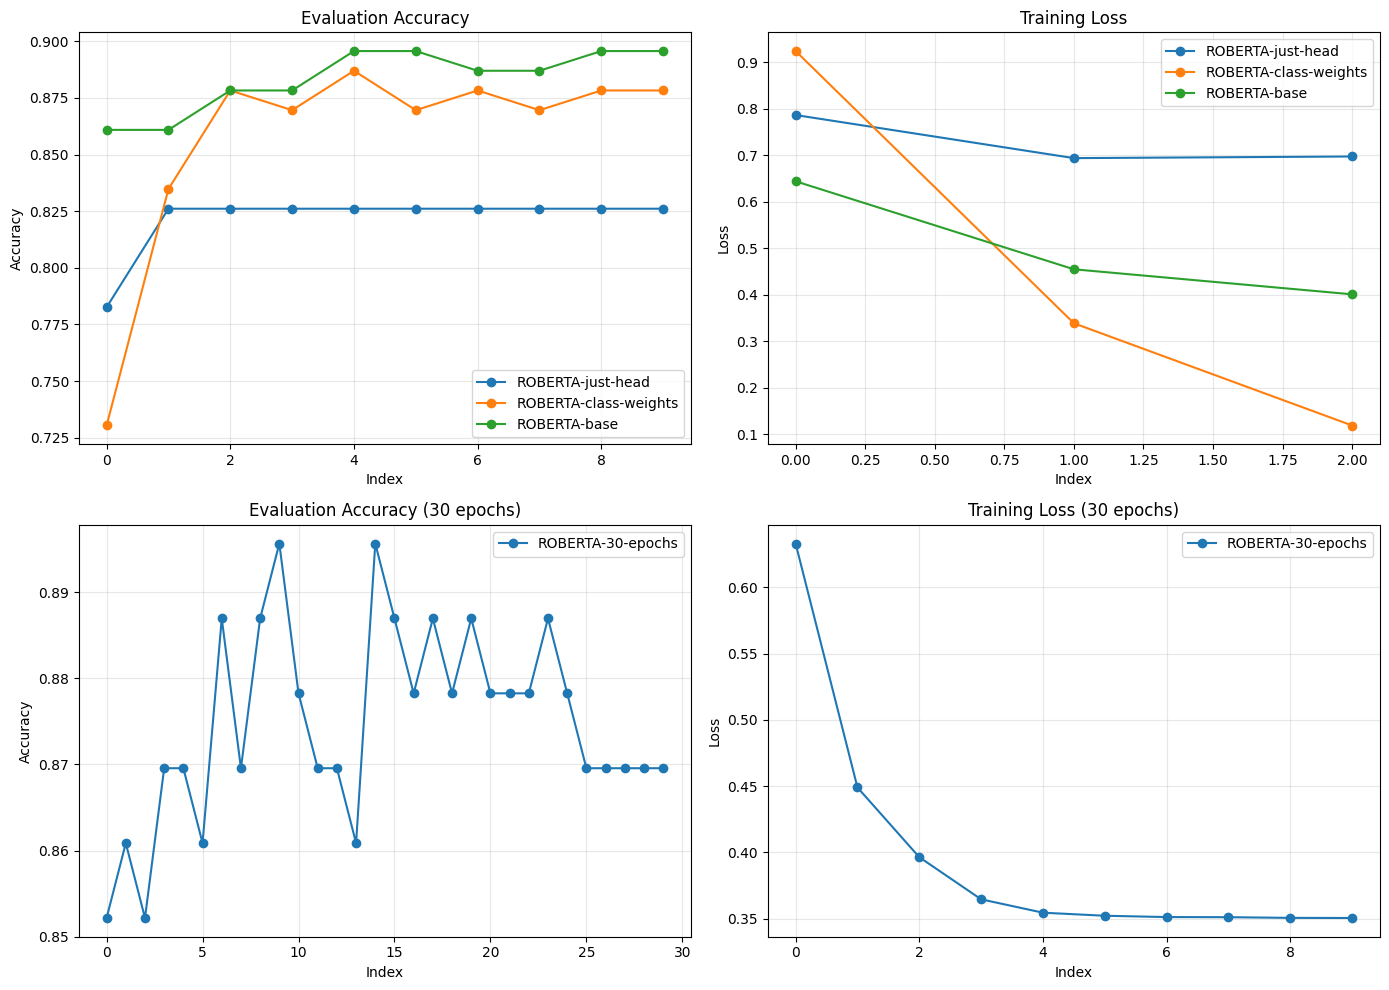

In [ ]:
# Drop only NaN cells (individual values)
eval_acc_clean = eval_acc.dropna(axis=0)
train_loss_clean = train_loss.dropna(axis=0)
eval_acc_30e_clean = eval_acc_30e.dropna(axis=0)
train_loss_30e_clean = train_loss_30e.dropna(axis=0)

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot eval_acc
eval_acc_clean.plot(ax=axes[0, 0], marker="o")
axes[0, 0].set_title("Evaluation Accuracy")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot train_loss
train_loss_clean.plot(ax=axes[0, 1], marker="o")
axes[0, 1].set_title("Training Loss")
axes[0, 1].set_xlabel("Index")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot eval_acc_30e
eval_acc_30e_clean.plot(ax=axes[1, 0], marker="o")
axes[1, 0].set_title("Evaluation Accuracy (30 epochs)")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Accuracy")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot train_loss_30e
train_loss_30e_clean.plot(ax=axes[1, 1], marker="o")
axes[1, 1].set_title("Training Loss (30 epochs)")
axes[1, 1].set_xlabel("Index")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
eval_f1 = pd.read_csv("eval_f1.csv", sep=";").dropna(axis=0)
eval_f1_30e = pd.read_csv("30e_eval_f1.csv", sep=";").dropna(axis=0)

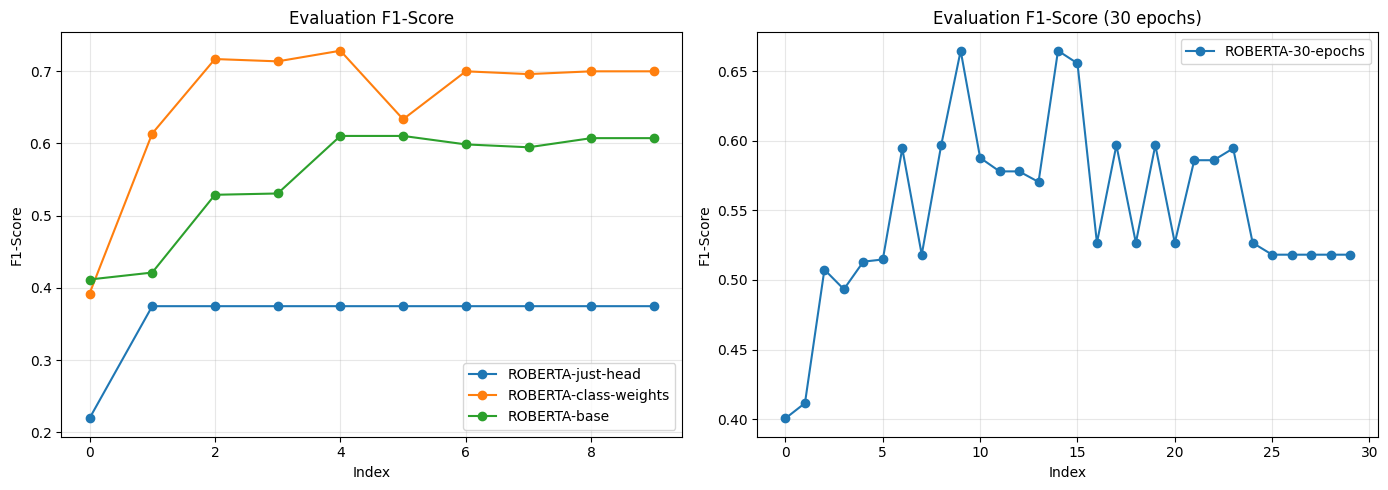

In [ ]:
# Drop only NaN cells (individual values)
eval_f1_clean = eval_f1.dropna(axis=0)
eval_f1_30e_clean = eval_f1_30e.dropna(axis=0)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot eval_f1
eval_f1_clean.plot(ax=axes[0], marker="o")
axes[0].set_title("Evaluation F1-Score")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("F1-Score")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot eval_f1_30e
eval_f1_30e_clean.plot(ax=axes[1], marker="o")
axes[1].set_title("Evaluation F1-Score (30 epochs)")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("F1-Score")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Train of the best ablation model respect F1 score (macro) for different seeds

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Store models and trainers
model_3_seeds = {}

for seed in SEEDS:
    print(f"\nTraining Model 3 with Seed {seed}...")

    # Create model
    model_3 = AutoModelForSequenceClassification.from_pretrained(
        MODEL,
        num_labels=NUM_CLASSES,
        id2label={0: "-", 1: "DIRECT", 2: "JUDGEMENTAL", 3: "REPORTED"},
        label2id={"-": 0, "DIRECT": 1, "JUDGEMENTAL": 2, "REPORTED": 3},
        ignore_mismatched_sizes=True,
    )

    # Training args for model 3 (default 10 epochs)
    training_args_3 = TrainingArguments(
        output_dir=f"test_dir_model3_{seed}",
        learning_rate=2e-5,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=10,
        weight_decay=0.01,
        seed=seed,
        lr_scheduler_type="cosine",
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        metric_for_best_model="f1",
        load_best_model_at_end=True,
        logging_steps=100,
        label_smoothing_factor=0.1,
        report_to="wandb",
        run_name=f"ROBERTA-class-weights_seed{seed}",
    )

    # Create weighted loss trainer for model 3
    trainer_3 = WeightedLossTrainer(
        model=model_3,
        args=training_args_3,
        train_dataset=encoded_train,
        eval_dataset=encoded_val,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    # Train the model
    trainer_3.train()

    api = HfApi()
    repo_id = f"nlp-transformer-weights_seed{seed}"
    api.create_repo(repo_id=repo_id)
    print(f"Repository created successfully")

    # Save to HuggingFace Hub
    print(f"Saving Model 3 (Seed {seed}) to HuggingFace Hub...")
    model_3.push_to_hub(f"nlp-transformer-weights_seed{seed}", private=False)

    # Store the trainer
    model_3_seeds[seed] = trainer_3

    wandb.finish()
    print(f"Model 3 (Seed {seed}) training and saving completed!")

print("\n" + "=" * 70)
print("MODEL 3 TRAINING COMPLETE FOR ALL SEEDS")
print("=" * 70)

In [ ]:
seed_eval_acc = pd.read_csv("seed_eval_acc.csv", sep=";")
seed_train_loss = pd.read_csv("seed_train_loss.csv", sep=";")

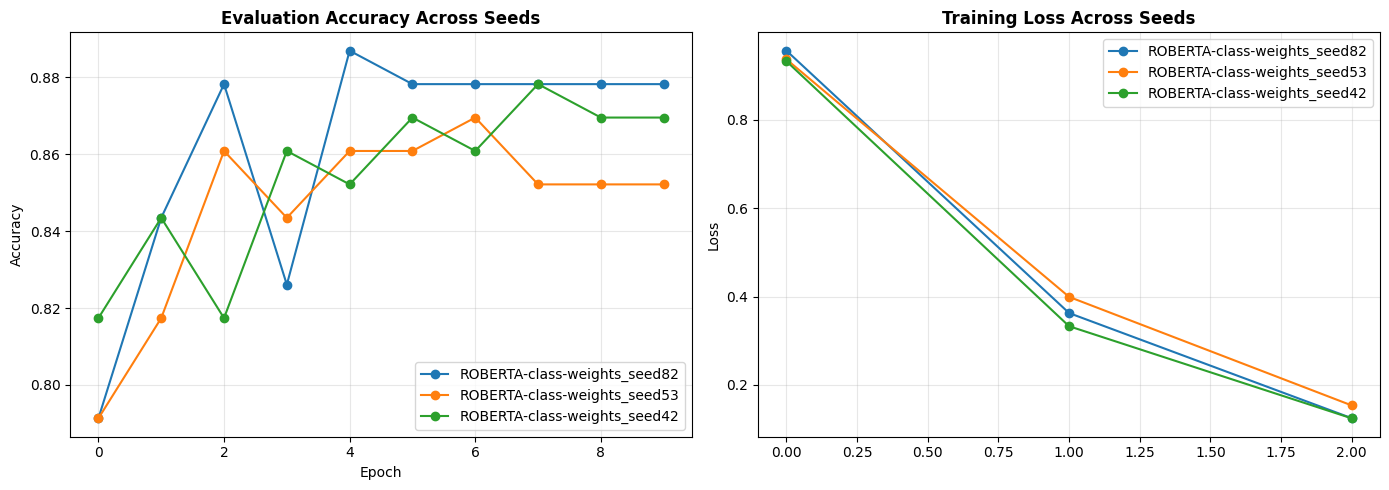

In [ ]:
# Drop NaN values for clean plotting
seed_eval_acc_clean = seed_eval_acc.dropna(axis=0)
seed_train_loss_clean = seed_train_loss.dropna(axis=0)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot evaluation accuracy
seed_eval_acc_clean.plot(ax=axes[0], marker="o")
axes[0].set_title("Evaluation Accuracy Across Seeds", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True, alpha=0.3)

# Plot training loss
seed_train_loss_clean.plot(ax=axes[1], marker="o")
axes[1].set_title("Training Loss Across Seeds", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Loss")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
y_test = test["label"].values
seed_metrics = {}
seed_predictions = {}

for seed in SEEDS:
    repo_id_to_load = f"mpreda/nlp-transformer-weights_seed{seed}"

    # Ensure distinct cache directory for each seed to prevent caching issues
    unique_cache_dir = f"./huggingface_cache_seed_{seed}"
    os.makedirs(unique_cache_dir, exist_ok=True)

    # Load the model directly from the Hugging Face Hub
    model = AutoModelForSequenceClassification.from_pretrained(
        repo_id_to_load,
        cache_dir=unique_cache_dir,  # Use a unique cache directory
        force_download=True,  # Force download to bypass any local cache conflicts
    )

    # Ensure model is in evaluation mode and on the correct device
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Manually prepare inputs from encoded_test for direct model prediction
    input_ids = torch.tensor(encoded_test["input_ids"], dtype=torch.long).to(device)
    attention_mask = torch.tensor(encoded_test["attention_mask"], dtype=torch.long).to(
        device
    )

    # Make predictions (get logits) without gradients
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Move logits to CPU and convert to numpy for metric computation
    test_predictions_seed = logits.cpu().numpy()
    seed_predictions[seed] = test_predictions_seed

    # Compute metrics using y_test
    seed_metrics[seed] = compute_metrics([test_predictions_seed, y_test])

    # Clean up model and GPU memory for the next iteration
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    import gc

    gc.collect()

In [ ]:
print("\n" + "=" * 70)
print("AVERAGE TRANSFORMER METRICS ACROSS SEEDS")
print("=" * 70)

f1_mean = np.mean([seed_metrics[seed]["f1"] for seed in SEEDS])
f1_std = np.std([seed_metrics[seed]["f1"] for seed in SEEDS])
precision_mean = np.mean([seed_metrics[seed]["precision"] for seed in SEEDS])
precision_std = np.std([seed_metrics[seed]["precision"] for seed in SEEDS])
recall_mean = np.mean([seed_metrics[seed]["recall"] for seed in SEEDS])
recall_std = np.std([seed_metrics[seed]["recall"] for seed in SEEDS])

print(f"  F1-Score (macro):     {f1_mean:.4f} \u00b1 {f1_std:.4f}")
print(f"  Precision (macro):    {precision_mean:.4f} \u00b1 {precision_std:.4f}")
print(f"  Recall (macro):       {recall_mean:.4f} \u00b1 {recall_std:.4f}")


AVERAGE TRANSFORMER METRICS ACROSS SEEDS
  F1-Score (macro):     0.5245 ± 0.0533
  Precision (macro):    0.5091 ± 0.0441
  Recall (macro):       0.5696 ± 0.0832


## Multilingual model

In [ ]:
train_multi = pd.read_json("data/training.json", orient="index")
val_multi = pd.read_json("data/validation.json", orient="index")
test_multi = pd.read_json("data/test.json", orient="index")

In [ ]:
# Label mapping for Task 2
label_map = {"-": 0, "DIRECT": 1, "JUDGEMENTAL": 2, "REPORTED": 3}

# Process train, validation, and test sets - INCLUDING BOTH EN AND ES
for name in ("train_multi", "val_multi", "test_multi"):
    df = globals()[name].copy()

    # Step 1: Aggregate labels using majority voting
    df["label"] = df["labels_task2"].apply(majority_vote)

    # Remove items without a clear majority
    df = df.dropna(subset=["label"])

    # Step 2: Filter to keep BOTH English ('en') and Spanish ('es') rows
    df = df[df["lang"].isin(["en", "es"])]

    # Step 3: Keep only required columns
    df = df[["id_EXIST", "lang", "tweet", "label"]]

    # Step 4: Encode the label column
    df["label"] = df["label"].map(label_map)

    # Update the global variable
    globals()[name] = df.reset_index(drop=True)

print("MULTILINGUAL DATA PREPROCESSING COMPLETED")
print(f"Train set shape: {train_multi.shape}")
print(f"Validation set shape: {val_multi.shape}")
print(f"Test set shape: {test_multi.shape}")

print(f"\nLanguage distribution in train set:")
print(train_multi["lang"].value_counts())

print(f"\nLabel distribution in train set:")
print(train_multi["label"].value_counts().sort_index())

print(f"\nSample multilingual tweets:")
for i in range(min(3, len(train_multi))):
    lang = train_multi["lang"].iloc[i]
    label = train_multi["label"].iloc[i]
    tweet = train_multi["tweet"].iloc[i]
    print(f"{i + 1}. [{lang}] (label={label}): {tweet[:80]}...")

MULTILINGUAL DATA PREPROCESSING COMPLETED
Train set shape: (4521, 4)
Validation set shape: (467, 4)
Test set shape: (217, 4)

Language distribution in train set:
lang
es    2319
en    2202
Name: count, dtype: int64

Label distribution in train set:
label
0    3367
1     842
2     109
3     203
Name: count, dtype: int64

Sample multilingual tweets:
1. [es] (label=0): @ultimonomada_ Si comicsgate se parece en algo a gamergate pues muy bien por el ...
2. [es] (label=0): @Steven2897 Lee sobre Gamergate, y como eso ha cambiado la manera en la cual nos...
3. [es] (label=0): @yonkykong Aaah sí. Andrew Dobson. El que se dedicó a echar mierda del gamergate...


In [ ]:
# Download required NLTK data
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("averaged_perceptron_tagger_eng", quiet=True)

lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet POS tags for better lemmatization"""
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN  # Default to noun


def clean_tweet(text):
    """Clean tweet text by removing noise and performing lemmatization"""
    if not isinstance(text, str):
        return text

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove mentions (@user)
    text = re.sub(r"@\w+", "", text)

    # Remove hashtags (#example)
    text = re.sub(r"#\w+", "", text)

    # Remove emojis
    text = re.sub(r"[^\w\s\-\.\,\!\?\']", "", text)

    # Remove specific quote characters (curly quotes, etc.)
    text = re.sub(r'[""' "`´]", '"', text)  # noqa: RUF001

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove special characters and short tokens, then lemmatize
    cleaned_tokens = []
    pos_tags = nltk.pos_tag(tokens)

    for token, pos in pos_tags:
        # Skip if token is too short or only special characters
        if len(token) < 2:  # noqa: PLR2004
            continue
        # Lemmatize using POS tag
        wordnet_pos = get_wordnet_pos(pos)
        lemmatized = lemmatizer.lemmatize(token, pos=wordnet_pos)
        cleaned_tokens.append(lemmatized)

    return " ".join(cleaned_tokens)


# Apply cleaning to all multilingual datasets
print("Cleaning multilingual datasets...")
for name in ("train_multi", "val_multi", "test_multi"):
    print(f"Cleaning {name} set...")
    globals()[name]["tweet"] = globals()[name]["tweet"].apply(clean_tweet)

print("\nMultilingual data cleaning completed!")
print(f"\nSample cleaned multilingual tweets from train set:")
for i in range(min(3, len(train_multi))):
    lang = train_multi["lang"].iloc[i]
    label = train_multi["label"].iloc[i]
    tweet = train_multi["tweet"].iloc[i]
    print(f"{i + 1}. [{lang}] (label={label}): {tweet[:100]}...")

Cleaning multilingual datasets...
Cleaning train_multi set...
Cleaning val_multi set...
Cleaning test_multi set...

Multilingual data cleaning completed!

Sample cleaned multilingual tweets from train set:
1. [es] (label=0): si comicsgate se parece en algo gamergate pues muy bien por el acoso si se está haciendo un sabotaje...
2. [es] (label=0): lee sobre gamergate como eso ha cambiado la manera en la cual no comunicamos en el internet los fanb...
3. [es] (label=0): aaah sí andrew dobson el que se dedicó echar mierda del gamergate al más puro estilo white knight to...


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")


def encode_dataset(df, tokenizer, max_length=128):
    """Encode a dataframe using the tokenizer"""
    encodings = tokenizer(
        df["tweet"].tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt",
    )

    # Create a dataset with encodings and labels
    dataset = Dataset.from_dict(
        {
            "input_ids": encodings["input_ids"].tolist(),
            "attention_mask": encodings["attention_mask"].tolist(),
            "label": df["label"].tolist(),
        }
    )

    return dataset


# Encode all three datasets
print("Encoding multilingual datasets...")
encoded_train_multi = encode_dataset(train_multi, tokenizer)
encoded_val_multi = encode_dataset(val_multi, tokenizer)
encoded_test_multi = encode_dataset(test_multi, tokenizer)

print(f"\nEncoding completed!")
print(f"Encoded train set: {len(encoded_train_multi)} samples")
print(f"Encoded validation set: {len(encoded_val_multi)} samples")
print(f"Encoded test set: {len(encoded_test_multi)} samples")

# Display sample encoding
print(f"\nSample encoding from train set:")
sample = encoded_train_multi[0]
print(f"  Input IDs length: {len(sample['input_ids'])}")
print(f"  Attention mask length: {len(sample['attention_mask'])}")
print(f"  Label: {sample['label']}")

In [ ]:
os.environ["WANDB_PROJECT"] = "nlp_assignment"  # name your W&B project
os.environ["WANDB_LOG_MODEL"] = "false"  # dont log all model checkpoints

In [ ]:
# Compute class weights for multilingual dataset
class_weights_multi = compute_class_weight(
    "balanced",
    classes=np.unique(train_multi["label"].tolist()),
    y=train_multi["label"].tolist(),
)
class_weights_multi = torch.tensor(class_weights_multi, dtype=torch.float)


# Custom Weighted Loss Trainer for multilingual model
class WeightedLossTrainerMulti(Trainer):
    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        num_items_in_batch=None,  # noqa: ARG002
    ):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Move class_weights to the same device as labels
        loss_fct = CrossEntropyLoss(weight=class_weights_multi.to(labels.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


# Data collator for multilingual model
data_collator_multi = DataCollatorWithPadding(tokenizer=tokenizer)

# Store models and trainers for multilingual
model_multi_seeds = {}

for seed in SEEDS:
    print(f"\nTraining Multilingual Model with Seed {seed}...")

    # Create multilingual model with sequence classification head
    model_multi = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-multilingual-cased",
        num_labels=NUM_CLASSES,
        id2label={0: "-", 1: "DIRECT", 2: "JUDGEMENTAL", 3: "REPORTED"},
        label2id={"-": 0, "DIRECT": 1, "JUDGEMENTAL": 2, "REPORTED": 3},
        ignore_mismatched_sizes=True,
    )

    # Training args for multilingual model
    training_args_multi = TrainingArguments(
        output_dir=f"multilingual_model_seed{seed}",
        learning_rate=2e-5,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=10,
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        metric_for_best_model="f1",
        load_best_model_at_end=True,
        logging_steps=100,
        label_smoothing_factor=0.1,
        report_to="wandb",
        run_name=f"BERT-multilingual_seed{seed}",
        seed=seed,
    )

    # Create weighted loss trainer for multilingual model
    trainer_multi = WeightedLossTrainerMulti(
        model=model_multi,
        args=training_args_multi,
        train_dataset=encoded_train_multi,
        eval_dataset=encoded_val_multi,
        compute_metrics=compute_metrics,
        data_collator=data_collator_multi,
    )

    # Train the model
    print(f"Starting training for seed {seed}...")
    trainer_multi.train()

    # Save to HuggingFace Hub
    print(f"Saving Multilingual Model (Seed {seed}) to HuggingFace Hub...")
    model_multi.push_to_hub(
        f"{username}/nlp-transformer-multilingual_seed{seed}", private=False
    )

    # Store the trainer
    model_multi_seeds[seed] = trainer_multi

    wandb.finish()
    print(f"Multilingual Model (Seed {seed}) training and saving completed!")

print("\n" + "=" * 70)
print("MULTILINGUAL MODEL TRAINING COMPLETE FOR ALL SEEDS")
print("=" * 70)
print(f"Models saved for seeds: {SEEDS}")

In [ ]:
multi_eval_acc = pd.read_csv("multi_eval_acc.csv", sep=";")
multi_train_loss = pd.read_csv("multi_train_loss.csv", sep=";")

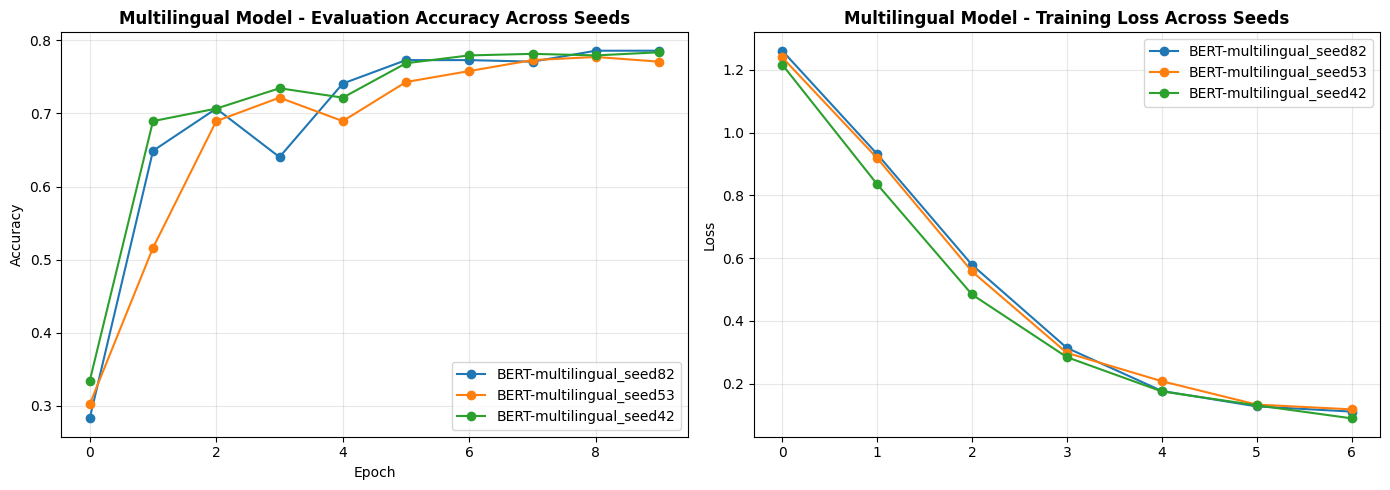

In [ ]:
multi_eval_acc_clean = multi_eval_acc.dropna(axis=0)
multi_train_loss_clean = multi_train_loss.dropna(axis=0)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot multilingual evaluation accuracy
multi_eval_acc_clean.plot(ax=axes[0], marker="o")
axes[0].set_title(
    "Multilingual Model - Evaluation Accuracy Across Seeds",
    fontsize=12,
    fontweight="bold",
)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True, alpha=0.3)

# Plot multilingual training loss
multi_train_loss_clean.plot(ax=axes[1], marker="o")
axes[1].set_title(
    "Multilingual Model - Training Loss Across Seeds", fontsize=12, fontweight="bold"
)
axes[1].set_ylabel("Loss")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Prepare test data
y_test_multi = test_multi["label"].values
seed_metrics_multi = {}
seed_predictions_multi = {}
loaded_model_identifiers_multi = []

for seed in SEEDS:
    print(f"\n--- Evaluating Multilingual Model - Seed: {seed} ---")
    repo_id_to_load = f"mpreda/nlp-transformer-multilingual_seed{seed}"
    print(f"Attempting to load model from: {repo_id_to_load}")

    # Ensure distinct cache directory for each seed
    unique_cache_dir = f"./huggingface_cache_multilingual_seed_{seed}"
    os.makedirs(unique_cache_dir, exist_ok=True)

    # Load the multilingual model
    model_eval = AutoModelForSequenceClassification.from_pretrained(
        repo_id_to_load, cache_dir=unique_cache_dir, force_download=True
    )

    # Debugging: Get unique identifier for loaded model's weights
    if (
        hasattr(model_eval, "classifier")
        and hasattr(model_eval.classifier, "out_proj")
        and hasattr(model_eval.classifier.out_proj, "weight")
    ):
        classifier_weight_sum = model_eval.classifier.out_proj.weight.sum().item()
        print(
           f"Loaded model's classifier.out_proj.weight sum: {classifier_weight_sum:.5f}"
        )
        loaded_model_identifiers_multi.append(classifier_weight_sum)
    else:
        print("  Could not retrieve specific weight sum for debugging.")
        loaded_model_identifiers_multi.append(None)

    # Ensure model is in evaluation mode and on the correct device
    model_eval.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_eval.to(device)

    # Manually prepare inputs from encoded_test_multi
    input_ids = torch.tensor(encoded_test_multi["input_ids"], dtype=torch.long).to(
        device
    )
    attention_mask = torch.tensor(
        encoded_test_multi["attention_mask"], dtype=torch.long
    ).to(device)

    # Make predictions (get logits) without gradients
    with torch.no_grad():
        outputs = model_eval(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Move logits to CPU and convert to numpy for metric computation
    test_predictions_seed_multi = logits.cpu().numpy()
    seed_predictions_multi[seed] = test_predictions_seed_multi

    # Compute metrics using y_test_multi
    seed_metrics_multi[seed] = compute_metrics(
        [test_predictions_seed_multi, y_test_multi]
    )

    # Clean up model and GPU memory
    del model_eval
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    import gc

    gc.collect()

In [ ]:
print("\n" + "=" * 70)
print("MULTILINGUAL MODEL - AVERAGE METRICS ACROSS SEEDS")
print("=" * 70)

f1_mean_multi = np.mean([seed_metrics_multi[seed]["f1"] for seed in SEEDS])
f1_std_multi = np.std([seed_metrics_multi[seed]["f1"] for seed in SEEDS])
precision_mean_multi = np.mean(
    [seed_metrics_multi[seed]["precision"] for seed in SEEDS]
)
precision_std_multi = np.std([seed_metrics_multi[seed]["precision"] for seed in SEEDS])
recall_mean_multi = np.mean([seed_metrics_multi[seed]["recall"] for seed in SEEDS])
recall_std_multi = np.std([seed_metrics_multi[seed]["recall"] for seed in SEEDS])

print(f"  F1-Score (macro):     {f1_mean_multi:.4f} ± {f1_std_multi:.4f}")
print(f"  Precision (macro):    {precision_mean_multi:.4f} ± {precision_std_multi:.4f}")
print(f"  Recall (macro):       {recall_mean_multi:.4f} ± {recall_std_multi:.4f}")


MULTILINGUAL MODEL - AVERAGE METRICS ACROSS SEEDS
  F1-Score (macro):     0.5339 ± 0.0155
  Precision (macro):    0.5085 ± 0.0110
  Recall (macro):       0.6076 ± 0.0244


# [Task 7 - 0.5 points] Error Analysis

After evaluating the model, perform a brief error analysis on the **test set**:

### Instructions

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

In [ ]:
# Get test predictions from the best LSTM model
base_lstm_model = models[SEEDS[0]]["baseline_model"]  # or 'stacked_model' if better
stack_lstm_model = models[SEEDS[0]]["stacked_model"]

base_test_pred = base_lstm_model.predict(test_padded, verbose=0)
base_test_pred_classes = np.argmax(base_test_pred, axis=1)

stack_test_pred = stack_lstm_model.predict(test_padded, verbose=0)
stack_test_pred_classes = np.argmax(stack_test_pred, axis=1)

# Get transformer test predictions from the first seed
transformer_logits = seed_predictions[SEEDS[0]]
transformer_test_pred_classes = np.argmax(transformer_logits, axis=1)

print(f"Base LSTM predictions shape: {base_test_pred_classes.shape}")
print(f"Stacked LSTM predictions shape: {stack_test_pred_classes.shape}")
print(f"Transformer predictions shape: {transformer_test_pred_classes.shape}")
print(f"Test labels shape: {y_test.shape}")

Base LSTM predictions shape: (217,)
Stacked LSTM predictions shape: (217,)
Transformer predictions shape: (217,)
Test labels shape: (217,)


# Confiusion matrixes

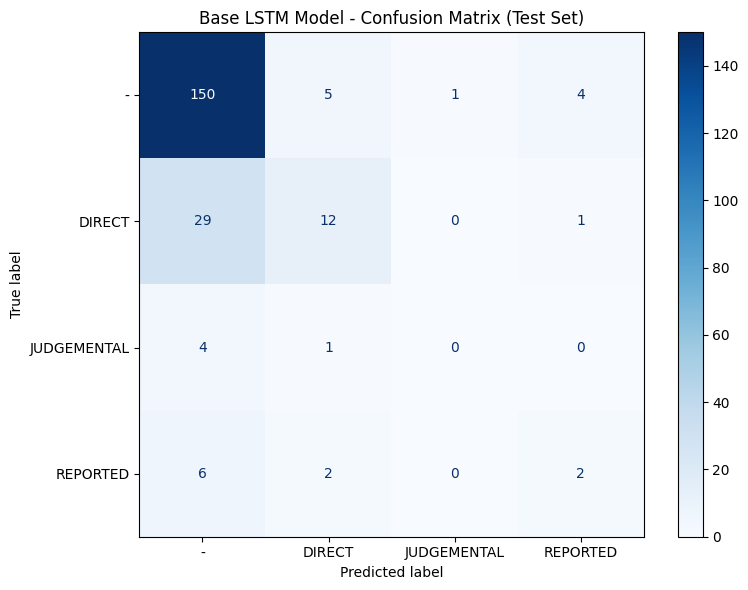

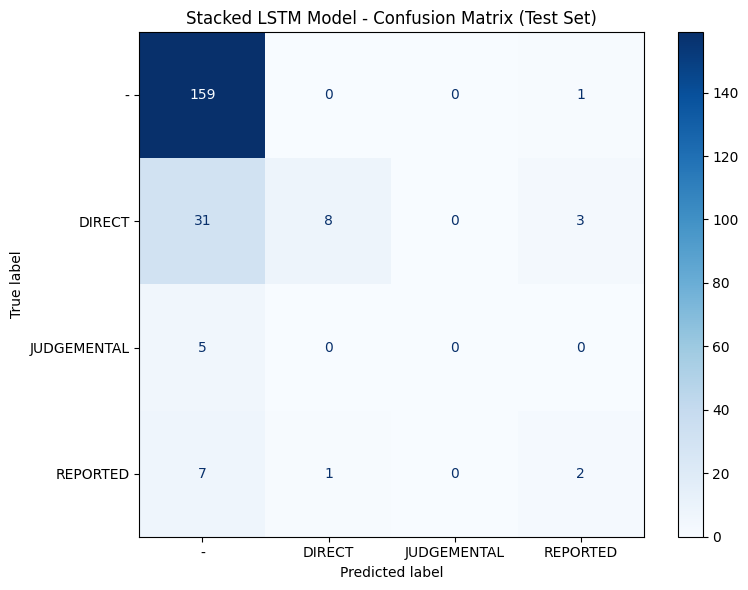

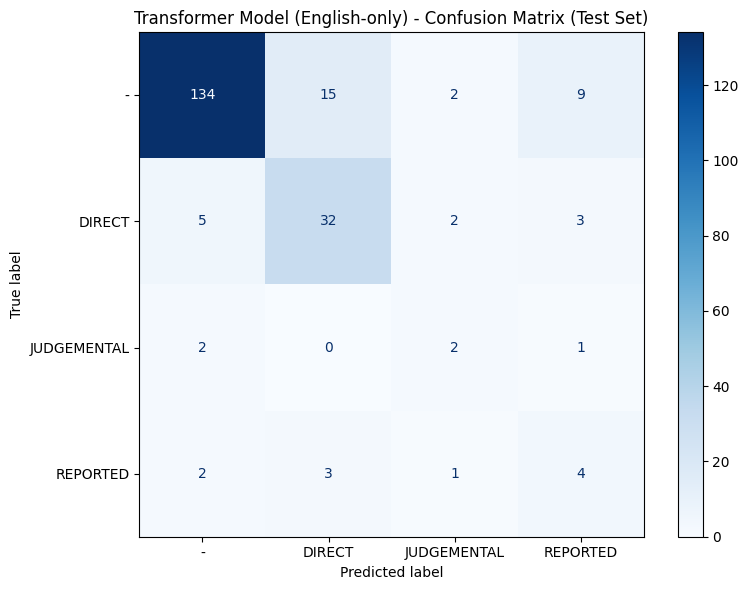

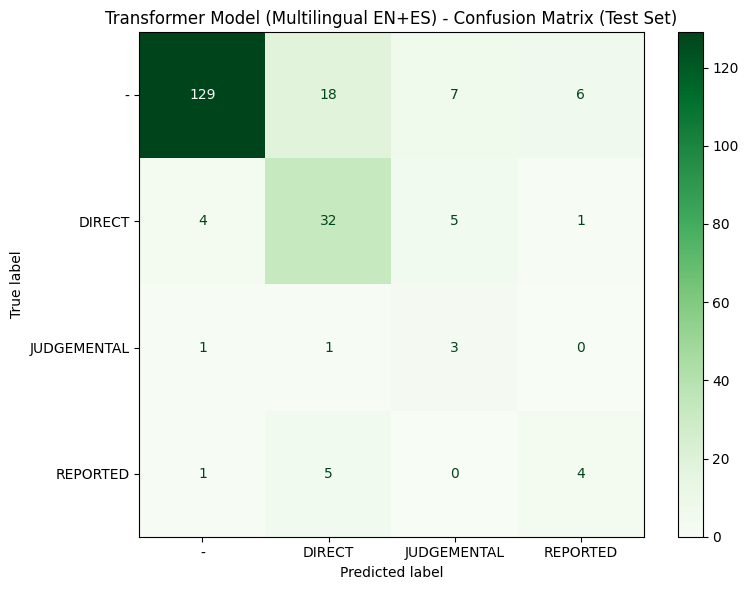

In [ ]:
# Class names
class_names = ["-", "DIRECT", "JUDGEMENTAL", "REPORTED"]

# LSTM Confusion Matrix
base_lstm_cm = confusion_matrix(y_test, base_test_pred_classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=base_lstm_cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues")
plt.title("Base LSTM Model - Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig("lstm_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

stack_lstm_cm = confusion_matrix(y_test, stack_test_pred_classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=stack_lstm_cm, display_labels=class_names
)
disp.plot(ax=ax, cmap="Blues")
plt.title("Stacked LSTM Model - Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig("lstm_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Transformer Confusion Matrix
transformer_cm = confusion_matrix(y_test, transformer_test_pred_classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=transformer_cm, display_labels=class_names
)
disp.plot(ax=ax, cmap="Blues")
plt.title("Transformer Model (English-only) - Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig("transformer_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Multilingual Transformer Confusion Matrix
transformer_multi_logits = seed_predictions_multi[SEEDS[0]]
transformer_multi_test_pred_classes = np.argmax(transformer_multi_logits, axis=1)

transformer_multi_cm = confusion_matrix(
    y_test_multi, transformer_multi_test_pred_classes
)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=transformer_multi_cm, display_labels=class_names
)
disp.plot(ax=ax, cmap="Greens")
plt.title("Transformer Model (Multilingual EN+ES) - Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig("transformer_multi_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Recall/Precision curves

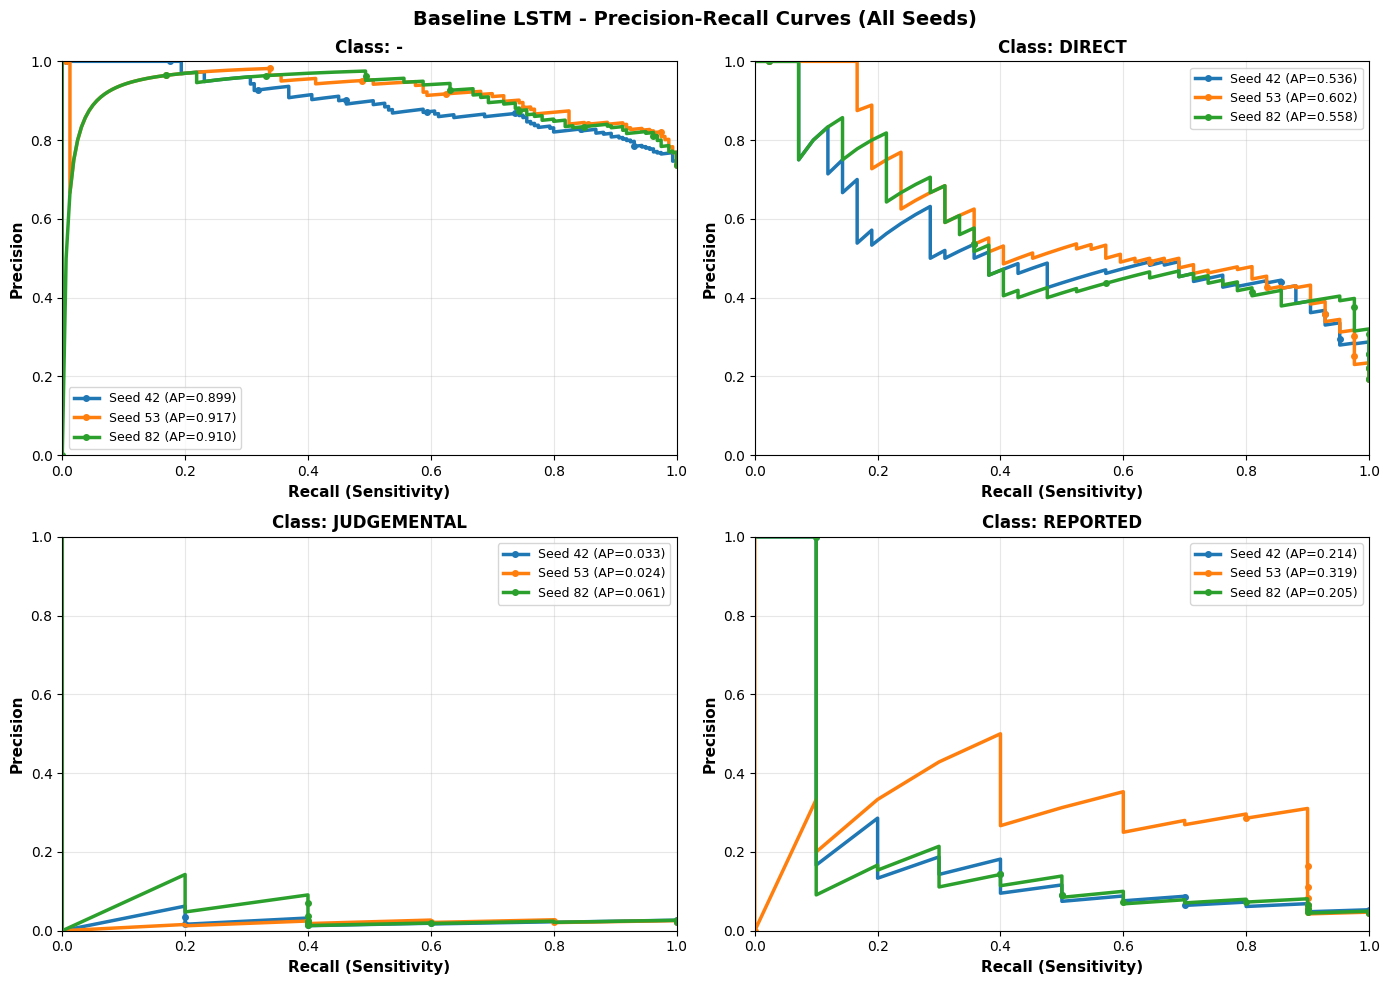

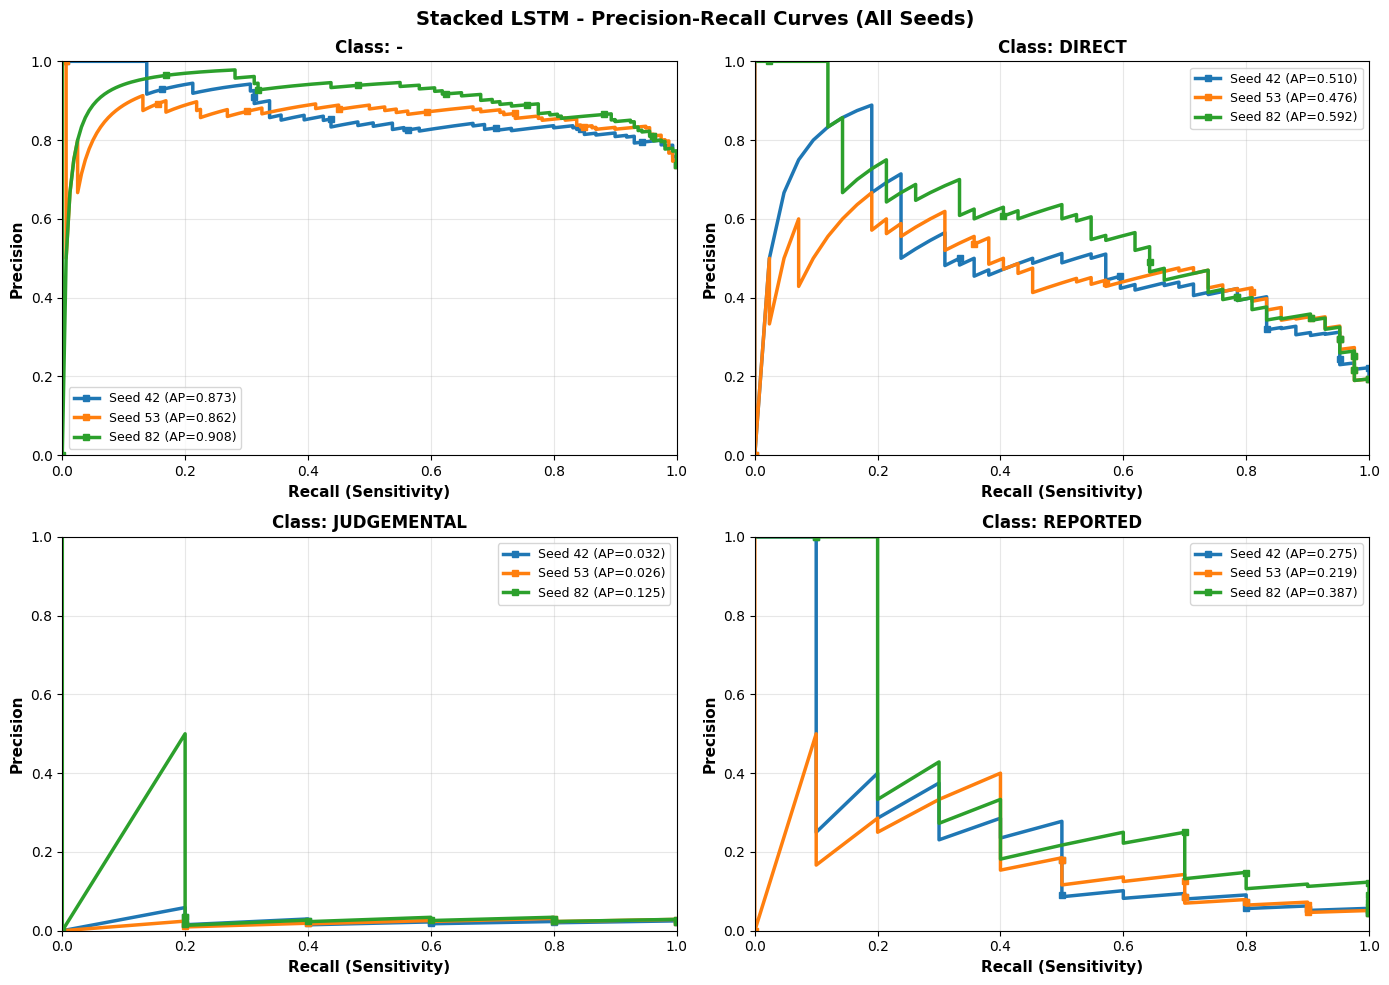

In [ ]:
# Class names
class_names = ["-", "DIRECT", "JUDGEMENTAL", "REPORTED"]

# Binarize test labels for multi-class PR curves
y_test_bin = label_binarize(y_test, classes=range(NUM_CLASSES))

colors_seeds = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

# Create figures for Baseline and Stacked models
fig_baseline, axes_baseline = plt.subplots(2, 2, figsize=(14, 10))
fig_baseline.suptitle(
    "Baseline LSTM - Precision-Recall Curves (All Seeds)",
    fontsize=14,
    fontweight="bold",
)

fig_stacked, axes_stacked = plt.subplots(2, 2, figsize=(14, 10))
fig_stacked.suptitle(
    "Stacked LSTM - Precision-Recall Curves (All Seeds)", fontsize=14, fontweight="bold"
)

axes_base = axes_baseline.ravel()
axes_stack = axes_stacked.ravel()

# Storage for AP scores
ap_data = {"Seed": [], "Model": [], "Class": [], "AP_Score": []}

for class_idx in range(NUM_CLASSES):
    for seed_idx, seed in enumerate(SEEDS):
        # Get predictions for current seed
        baseline_pred = models[seed]["baseline_model"].predict(test_padded, verbose=0)
        stacked_pred = models[seed]["stacked_model"].predict(test_padded, verbose=0)

        # Baseline model - Precision-Recall curve
        precision_base, recall_base, _ = precision_recall_curve(
            y_test_bin[:, class_idx], baseline_pred[:, class_idx]
        )
        ap_base = average_precision_score(
            y_test_bin[:, class_idx], baseline_pred[:, class_idx]
        )

        # Stacked model - Precision-Recall curve
        precision_stack, recall_stack, _ = precision_recall_curve(
            y_test_bin[:, class_idx], stacked_pred[:, class_idx]
        )
        ap_stack = average_precision_score(
            y_test_bin[:, class_idx], stacked_pred[:, class_idx]
        )

        # Plot Baseline PR Curve (Recall vs Precision)
        axes_base[class_idx].plot(
            recall_base,
            precision_base,
            label=f"Seed {seed} (AP={ap_base:.3f})",
            linewidth=2.5,
            color=colors_seeds[seed_idx],
            marker="o",
            markersize=4,
            markevery=max(1, len(recall_base) // 8),
        )

        # Plot Stacked PR Curve (Recall vs Precision)
        axes_stack[class_idx].plot(
            recall_stack,
            precision_stack,
            label=f"Seed {seed} (AP={ap_stack:.3f})",
            linewidth=2.5,
            color=colors_seeds[seed_idx],
            marker="s",
            markersize=4,
            markevery=max(1, len(recall_stack) // 8),
        )

    # Configure Baseline subplot
    axes_base[class_idx].set_xlabel(
        "Recall (Sensitivity)", fontsize=11, fontweight="bold"
    )
    axes_base[class_idx].set_ylabel("Precision", fontsize=11, fontweight="bold")
    axes_base[class_idx].set_title(
        f"Class: {class_names[class_idx]}", fontsize=12, fontweight="bold"
    )
    axes_base[class_idx].legend(fontsize=9, loc="best")
    axes_base[class_idx].grid(True, alpha=0.3)
    axes_base[class_idx].set_xlim([0, 1])
    axes_base[class_idx].set_ylim([0, 1])

    # Configure Stacked subplot
    axes_stack[class_idx].set_xlabel(
        "Recall (Sensitivity)", fontsize=11, fontweight="bold"
    )
    axes_stack[class_idx].set_ylabel("Precision", fontsize=11, fontweight="bold")
    axes_stack[class_idx].set_title(
        f"Class: {class_names[class_idx]}", fontsize=12, fontweight="bold"
    )
    axes_stack[class_idx].legend(fontsize=9, loc="best")
    axes_stack[class_idx].grid(True, alpha=0.3)
    axes_stack[class_idx].set_xlim([0, 1])
    axes_stack[class_idx].set_ylim([0, 1])

fig_baseline.tight_layout()

fig_stacked.tight_layout()

plt.show()

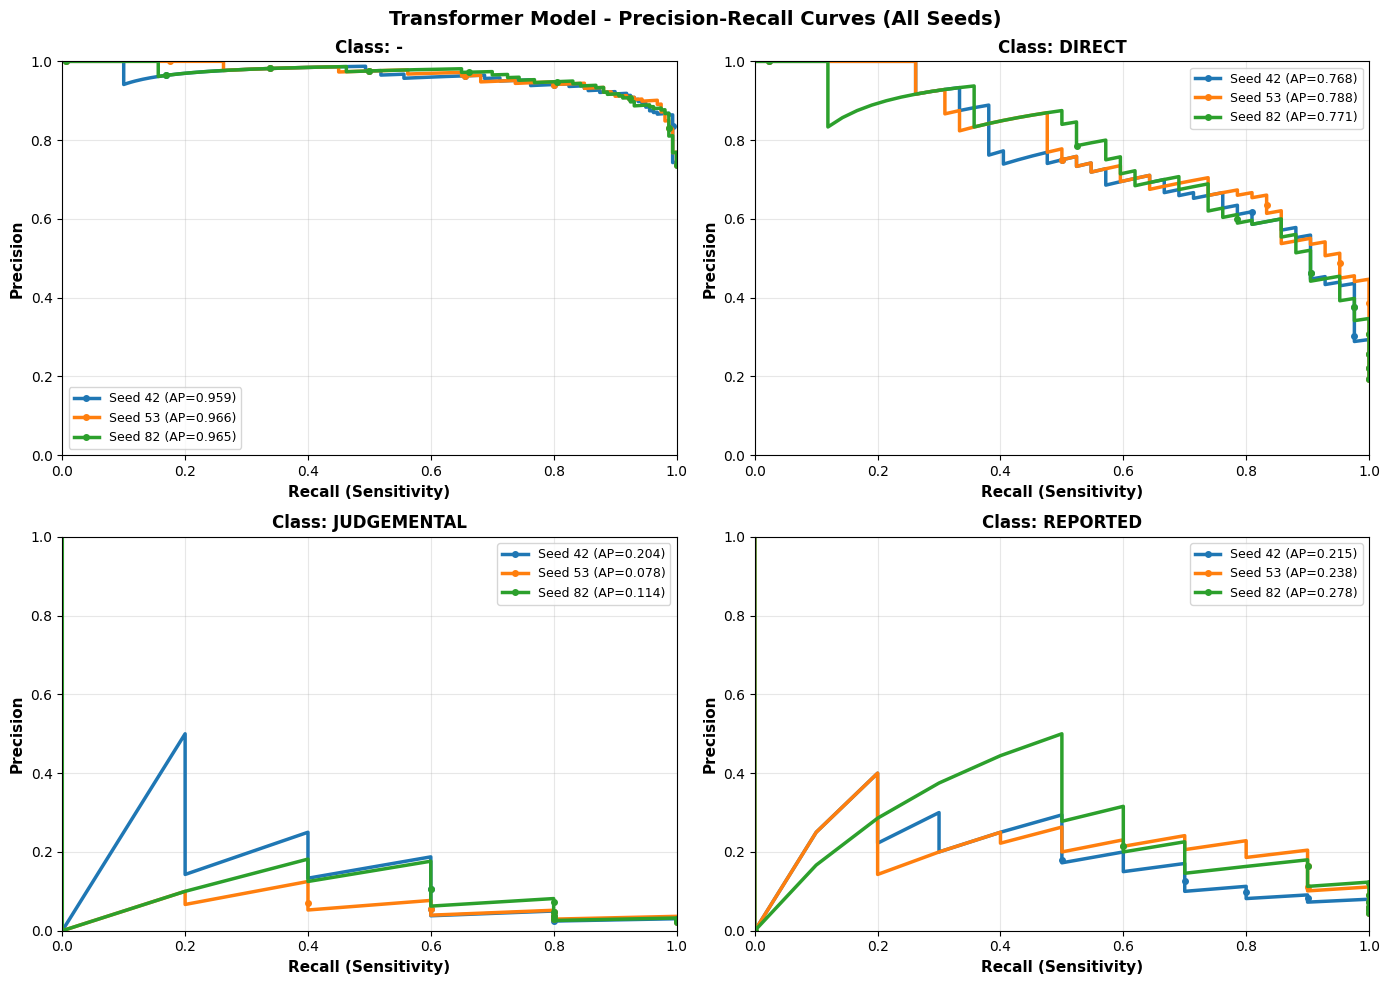

In [ ]:
# Binarize test labels for multi-class PR curves
y_test_bin = label_binarize(y_test, classes=range(NUM_CLASSES))

colors_seeds = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

# Create figure for Transformer model
fig_transformer, axes_transformer = plt.subplots(2, 2, figsize=(14, 10))
fig_transformer.suptitle(
    "Transformer Model - Precision-Recall Curves (All Seeds)",
    fontsize=14,
    fontweight="bold",
)

axes_trans = axes_transformer.ravel()

# Plot precision-recall curves for each class and seed
for class_idx in range(NUM_CLASSES):
    for seed_idx, seed in enumerate(SEEDS):
        # Get predictions for current seed - convert logits to probabilities
        transformer_logits = seed_predictions[seed]
        transformer_probs = softmax(transformer_logits, axis=1)

        # Transformer model - Precision-Recall curve
        precision_trans, recall_trans, _ = precision_recall_curve(
            y_test_bin[:, class_idx], transformer_probs[:, class_idx]
        )
        ap_trans = average_precision_score(
            y_test_bin[:, class_idx], transformer_probs[:, class_idx]
        )

        # Plot Transformer PR Curve (Recall vs Precision)
        axes_trans[class_idx].plot(
            recall_trans,
            precision_trans,
            label=f"Seed {seed} (AP={ap_trans:.3f})",
            linewidth=2.5,
            color=colors_seeds[seed_idx],
            marker="o",
            markersize=4,
            markevery=max(1, len(recall_trans) // 8),
        )

    # Configure Transformer subplot
    axes_trans[class_idx].set_xlabel(
        "Recall (Sensitivity)", fontsize=11, fontweight="bold"
    )
    axes_trans[class_idx].set_ylabel("Precision", fontsize=11, fontweight="bold")
    axes_trans[class_idx].set_title(
        f"Class: {class_names[class_idx]}", fontsize=12, fontweight="bold"
    )
    axes_trans[class_idx].legend(fontsize=9, loc="best")
    axes_trans[class_idx].grid(True, alpha=0.3)
    axes_trans[class_idx].set_xlim([0, 1])
    axes_trans[class_idx].set_ylim([0, 1])

fig_transformer.tight_layout()
plt.show()

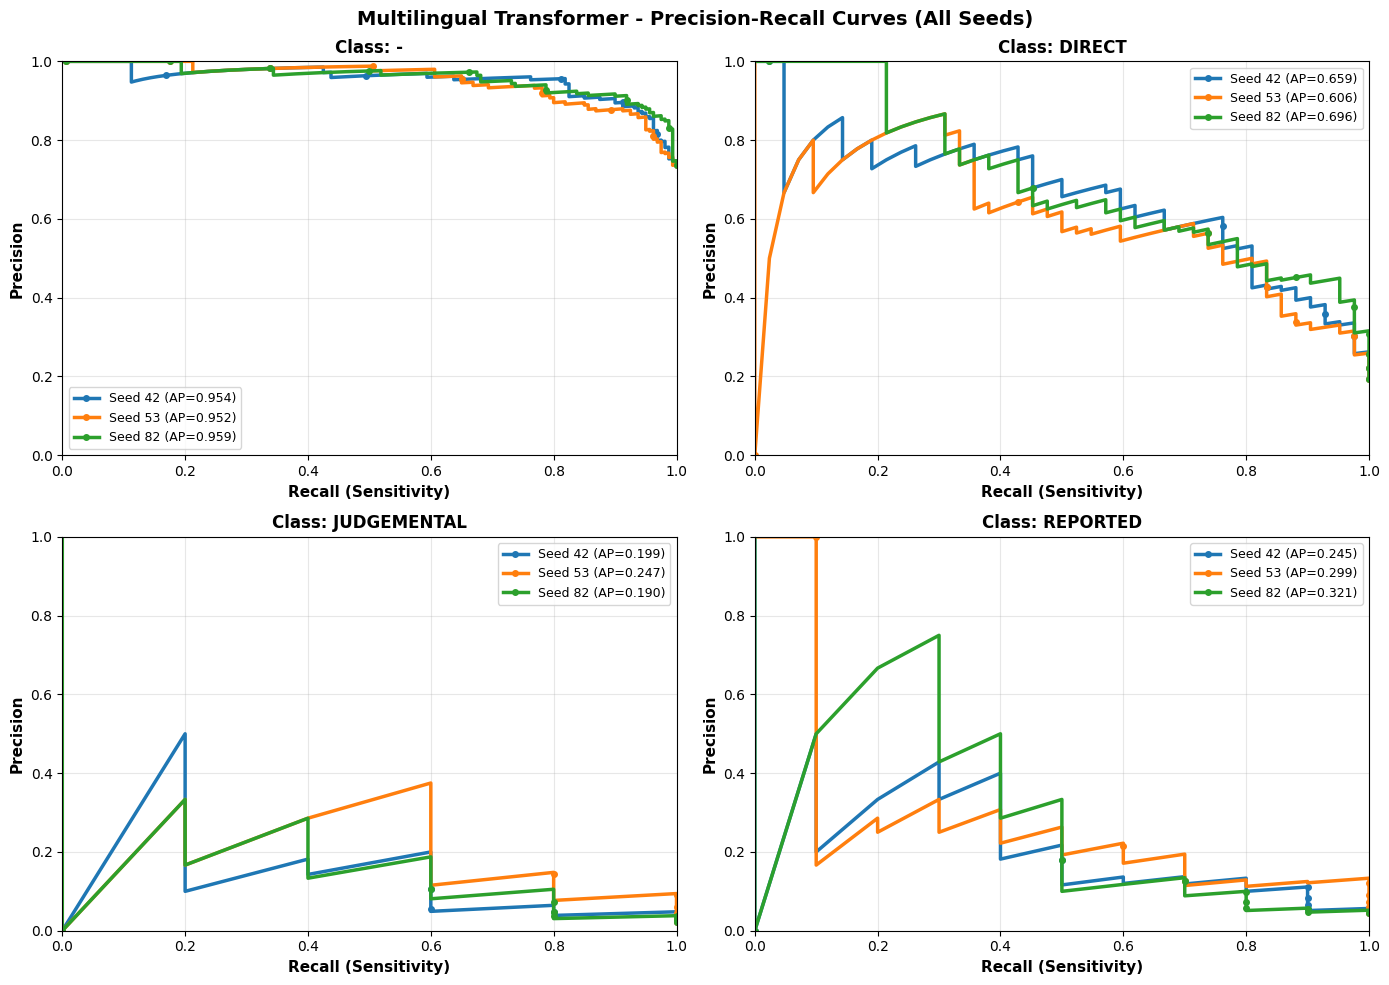

In [ ]:
# Binarize multilingual test labels for multi-class PR curves
y_test_multi_bin = label_binarize(y_test_multi, classes=range(NUM_CLASSES))

colors_seeds = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

# Create figure for Multilingual Transformer model
fig_multilingual, axes_multilingual = plt.subplots(2, 2, figsize=(14, 10))
fig_multilingual.suptitle(
    "Multilingual Transformer - Precision-Recall Curves (All Seeds)",
    fontsize=14,
    fontweight="bold",
)

axes_multi = axes_multilingual.ravel()

# Plot precision-recall curves for each class and seed
for class_idx in range(NUM_CLASSES):
    for seed_idx, seed in enumerate(SEEDS):
        # Get predictions for current seed - convert logits to probabilities
        multilingual_logits = seed_predictions_multi[seed]
        multilingual_probs = softmax(multilingual_logits, axis=1)

        # Multilingual model - Precision-Recall curve
        precision_multi, recall_multi, _ = precision_recall_curve(
            y_test_multi_bin[:, class_idx], multilingual_probs[:, class_idx]
        )
        ap_multi = average_precision_score(
            y_test_multi_bin[:, class_idx], multilingual_probs[:, class_idx]
        )

        # Plot Multilingual PR Curve (Recall vs Precision)
        axes_multi[class_idx].plot(
            recall_multi,
            precision_multi,
            label=f"Seed {seed} (AP={ap_multi:.3f})",
            linewidth=2.5,
            color=colors_seeds[seed_idx],
            marker="o",
            markersize=4,
            markevery=max(1, len(recall_multi) // 8),
        )

    # Configure Multilingual subplot
    axes_multi[class_idx].set_xlabel(
        "Recall (Sensitivity)", fontsize=11, fontweight="bold"
    )
    axes_multi[class_idx].set_ylabel("Precision", fontsize=11, fontweight="bold")
    axes_multi[class_idx].set_title(
        f"Class: {class_names[class_idx]}", fontsize=12, fontweight="bold"
    )
    axes_multi[class_idx].legend(fontsize=9, loc="best")
    axes_multi[class_idx].grid(True, alpha=0.3)
    axes_multi[class_idx].set_xlim([0, 1])
    axes_multi[class_idx].set_ylim([0, 1])

fig_multilingual.tight_layout()
plt.show()

# Prediction errors respect test lenght analysis 


ERROR DISTRIBUTION BY TEXT LENGTH - ENGLISH-ONLY TEST SET

Base LSTM:
----------------------------------------------------------------------
  0-20 tokens: Accuracy = 0.7294 (n=85)
  20-50 tokens: Accuracy = 0.7899 (n=119)
  50-100 tokens: Accuracy = 0.6154 (n=13)

Stacked LSTM:
----------------------------------------------------------------------
  0-20 tokens: Accuracy = 0.7294 (n=85)
  20-50 tokens: Accuracy = 0.8235 (n=119)
  50-100 tokens: Accuracy = 0.6923 (n=13)

Transformer:
----------------------------------------------------------------------
  0-20 tokens: Accuracy = 0.8118 (n=85)
  20-50 tokens: Accuracy = 0.7899 (n=119)
  50-100 tokens: Accuracy = 0.6923 (n=13)

ERROR DISTRIBUTION BY TEXT LENGTH - MULTILINGUAL (EN+ES) TEST SET

Transformer Multilingual:
----------------------------------------------------------------------
  0-20 tokens: Accuracy = 0.8118 (n=85)
  20-50 tokens: Accuracy = 0.7479 (n=119)
  50-100 tokens: Accuracy = 0.7692 (n=13)


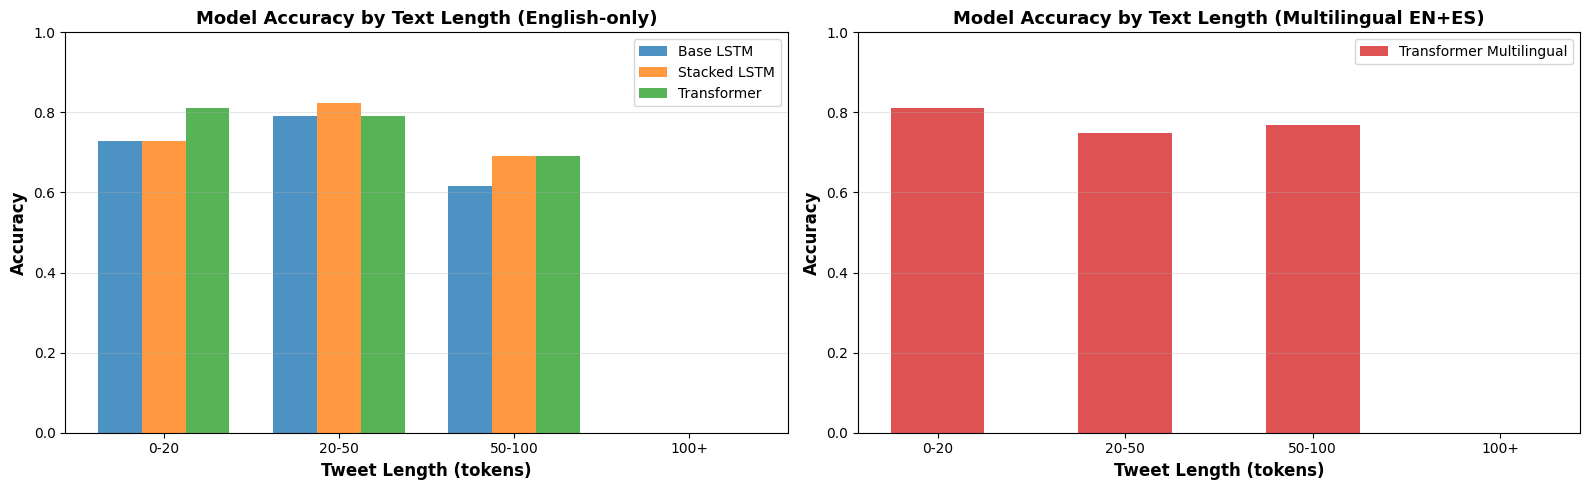


ERROR TYPES BY TEXT LENGTH - ENGLISH-ONLY

0-20 tokens (n=85):
  Transformer - Errors: 16 (18.8%)
    -: confused with {'DIRECT': 7, 'REPORTED': 3}
    DIRECT: confused with {'-': 5, 'JUDGEMENTAL': 1}

20-50 tokens (n=119):
  Transformer - Errors: 25 (21.0%)
    -: confused with {'DIRECT': 8, 'REPORTED': 5, 'JUDGEMENTAL': 2}
    DIRECT: confused with {'REPORTED': 2, 'JUDGEMENTAL': 1}
    JUDGEMENTAL: confused with {'-': 2}
    REPORTED: confused with {'-': 2, 'DIRECT': 2, 'JUDGEMENTAL': 1}

50-100 tokens (n=13):
  Transformer - Errors: 4 (30.8%)
    -: confused with {'REPORTED': 1}
    DIRECT: confused with {'REPORTED': 1}
    JUDGEMENTAL: confused with {'REPORTED': 1}
    REPORTED: confused with {'DIRECT': 1}

ERROR TYPES BY TEXT LENGTH - MULTILINGUAL (EN+ES)

0-20 tokens (n=85):
  Transformer Multilingual - Errors: 16 (18.8%)
    -: confused with {'DIRECT': 8, 'REPORTED': 2}
    DIRECT: confused with {'-': 4, 'JUDGEMENTAL': 2}

20-50 tokens (n=119):
  Transformer Multilingual - Erro

In [ ]:
# Calculate text lengths for test set
test_lengths = test["tweet"].apply(lambda x: len(word_tokenize(x)))

# Define length bins
length_bins = [0, 20, 50, 100, 500]
bin_labels = ["0-20", "20-50", "50-100", "100+"]

# Create binned data
binned_lengths = pd.cut(test_lengths, bins=length_bins, labels=bin_labels, right=False)

# Create a dataframe for analysis
error_analysis_df = pd.DataFrame(
    {
        "length_bin": binned_lengths,
        "tweet_length": test_lengths,
        "true_label": y_test,
        "base_lstm_pred": base_test_pred_classes,
        "stack_lstm_pred": stack_test_pred_classes,
        "transformer_pred": transformer_test_pred_classes,
    }
)

# For multilingual model, use multilingual test data lengths
test_lengths_multi = test_multi["tweet"].apply(lambda x: len(word_tokenize(x)))
binned_lengths_multi = pd.cut(
    test_lengths_multi, bins=length_bins, labels=bin_labels, right=False
)

error_analysis_df_multi = pd.DataFrame(
    {
        "length_bin": binned_lengths_multi,
        "tweet_length": test_lengths_multi,
        "true_label": y_test_multi,
        "transformer_multi_pred": transformer_multi_test_pred_classes,
    }
)

# Calculate accuracy by length bin for each model
print("\n" + "=" * 70)
print("ERROR DISTRIBUTION BY TEXT LENGTH - ENGLISH-ONLY TEST SET")
print("=" * 70)

accuracy_by_length = {}

for model_name, pred_col in [
    ("Base LSTM", "base_lstm_pred"),
    ("Stacked LSTM", "stack_lstm_pred"),
    ("Transformer", "transformer_pred"),
]:
    print(f"\n{model_name}:")
    print("-" * 70)

    accuracies = []
    support = []

    for bin_label in bin_labels:
        mask = error_analysis_df["length_bin"] == bin_label
        if mask.sum() > 0:
            bin_accuracy = (
                error_analysis_df[mask]["true_label"]
                == error_analysis_df[mask][pred_col]
            ).mean()
            bin_support = mask.sum()
            accuracies.append(bin_accuracy)
            support.append(bin_support)

            print(
                f"  {bin_label} tokens: Accuracy = {bin_accuracy:.4f} (n={bin_support})"
            )
        else:
            accuracies.append(0)
            support.append(0)

    accuracy_by_length[model_name] = {"accuracies": accuracies, "support": support}

# Calculate accuracy by length bin for multilingual model
print("\n" + "=" * 70)
print("ERROR DISTRIBUTION BY TEXT LENGTH - MULTILINGUAL (EN+ES) TEST SET")
print("=" * 70)

accuracy_by_length_multi = {}

print(f"\nTransformer Multilingual:")
print("-" * 70)

accuracies_multi = []
support_multi = []

for bin_label in bin_labels:
    mask = error_analysis_df_multi["length_bin"] == bin_label
    if mask.sum() > 0:
        bin_accuracy = (
            error_analysis_df_multi[mask]["true_label"]
            == error_analysis_df_multi[mask]["transformer_multi_pred"]
        ).mean()
        bin_support = mask.sum()
        accuracies_multi.append(bin_accuracy)
        support_multi.append(bin_support)

        print(f"  {bin_label} tokens: Accuracy = {bin_accuracy:.4f} (n={bin_support})")
    else:
        accuracies_multi.append(0)
        support_multi.append(0)

accuracy_by_length_multi["Transformer Multilingual"] = {
    "accuracies": accuracies_multi,
    "support": support_multi,
}

# Visualize error distribution by text length
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Accuracy by length bin (English-only models)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
x_pos = np.arange(len(bin_labels))
width = 0.25

for idx, (model_name, color) in enumerate(zip(accuracy_by_length.keys(), colors, strict=False)):  # noqa: E501
    accuracies = accuracy_by_length[model_name]["accuracies"]
    axes[0].bar(
        x_pos + idx * width, accuracies, width, label=model_name, color=color, alpha=0.8
    )

axes[0].set_xlabel("Tweet Length (tokens)", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Accuracy", fontsize=12, fontweight="bold")
axes[0].set_title(
    "Model Accuracy by Text Length (English-only)", fontsize=13, fontweight="bold"
)
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(bin_labels)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis="y")
axes[0].set_ylim([0, 1])

# Plot 2: Accuracy by length bin (Multilingual model)
accuracies_multi = accuracy_by_length_multi["Transformer Multilingual"]["accuracies"]
axes[1].bar(
    x_pos,
    accuracies_multi,
    width=0.5,
    label="Transformer Multilingual",
    color="#d62728",
    alpha=0.8,
)

axes[1].set_xlabel("Tweet Length (tokens)", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Accuracy", fontsize=12, fontweight="bold")
axes[1].set_title(
    "Model Accuracy by Text Length (Multilingual EN+ES)", fontsize=13, fontweight="bold"
)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(bin_labels)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis="y")
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Detailed error analysis by length
print("\n" + "=" * 70)
print("ERROR TYPES BY TEXT LENGTH - ENGLISH-ONLY")
print("=" * 70)

for bin_label in bin_labels:
    mask = error_analysis_df["length_bin"] == bin_label
    if mask.sum() > 0:
        print(f"\n{bin_label} tokens (n={mask.sum()}):")

        # For transformer model
        subset = error_analysis_df[mask]
        errors = subset["true_label"] != subset["transformer_pred"]

        if errors.sum() > 0:
            print(
                f"  Transformer - Errors: {errors.sum()} ({errors.mean() * 100:.1f}%)"
            )

            # Show confusion for errors
            error_subset = subset[errors]
            for true_label_idx, class_name in enumerate(class_names):
                mask_true = error_subset["true_label"] == true_label_idx
                if mask_true.sum() > 0:
                    pred_dist = error_subset[mask_true][
                        "transformer_pred"
                    ].value_counts()
                    # Map numeric predictions to class names
                    confusion_dict = {
                        class_names[int(pred_class)]: count
                        for pred_class, count in pred_dist.items()
                    }
                    print(f"    {class_name}: confused with {confusion_dict}")

# Detailed error analysis by length (Multilingual)
print("\n" + "=" * 70)
print("ERROR TYPES BY TEXT LENGTH - MULTILINGUAL (EN+ES)")
print("=" * 70)

for bin_label in bin_labels:
    mask = error_analysis_df_multi["length_bin"] == bin_label
    if mask.sum() > 0:
        print(f"\n{bin_label} tokens (n={mask.sum()}):")

        # For multilingual transformer model
        subset = error_analysis_df_multi[mask]
        errors = subset["true_label"] != subset["transformer_multi_pred"]

        if errors.sum() > 0:
            print(
                f"  Transformer Multilingual - Errors: {errors.sum()} ({errors.mean() * 100:.1f}%)"  # noqa: E501
            )

            # Show confusion for errors
            error_subset = subset[errors]
            for true_label_idx, class_name in enumerate(class_names):
                mask_true = error_subset["true_label"] == true_label_idx
                if mask_true.sum() > 0:
                    pred_dist = error_subset[mask_true][
                        "transformer_multi_pred"
                    ].value_counts()
                    # Map numeric predictions to class names
                    confusion_dict = {
                        class_names[int(pred_class)]: count
                        for pred_class, count in pred_dist.items()
                    }
                    print(f"    {class_name}: confused with {confusion_dict}")

# Per-class metrics

In [ ]:
# Per-class metrics
base_lstm_report = classification_report(
    y_test, base_test_pred_classes, target_names=class_names, output_dict=True
)
stack_lstm_report = classification_report(
    y_test, stack_test_pred_classes, target_names=class_names, output_dict=True
)
transformer_report = classification_report(
    y_test, transformer_test_pred_classes, target_names=class_names, output_dict=True
)
transformer_multi_report = classification_report(
    y_test_multi,
    transformer_multi_test_pred_classes,
    target_names=class_names,
    output_dict=True,
)

print("=" * 70)
print("BASE LSTM MODEL - PER-CLASS PERFORMANCE")
print("=" * 70)
print(classification_report(y_test, base_test_pred_classes, target_names=class_names))

print("=" * 70)
print("STACKED LSTM MODEL - PER-CLASS PERFORMANCE")
print("=" * 70)
print(classification_report(y_test, stack_test_pred_classes, target_names=class_names))

print("\n" + "=" * 70)
print("TRANSFORMER MODEL (ENGLISH-ONLY) - PER-CLASS PERFORMANCE")
print("=" * 70)
print(
    classification_report(
        y_test, transformer_test_pred_classes, target_names=class_names
    )
)

print("\n" + "=" * 70)
print("TRANSFORMER MODEL (MULTILINGUAL EN+ES) - PER-CLASS PERFORMANCE")
print("=" * 70)
print(
    classification_report(
        y_test_multi, transformer_multi_test_pred_classes, target_names=class_names
    )
)

# Summary comparison
comparison_df = pd.DataFrame(
    {
        "Class": class_names,
        "Base_LSTM_F1": [base_lstm_report[cn]["f1-score"] for cn in class_names],
        "Stack_LSTM_F1": [stack_lstm_report[cn]["f1-score"] for cn in class_names],
        "Transformer_EN_F1": [transformer_report[cn]["f1-score"] for cn in class_names],
        "Transformer_Multi_F1": [
            transformer_multi_report[cn]["f1-score"] for cn in class_names
        ],
        "Base_LSTM_Precision": [
            base_lstm_report[cn]["precision"] for cn in class_names
        ],
        "Stack_LSTM_Precision": [
            stack_lstm_report[cn]["precision"] for cn in class_names
        ],
        "Transformer_EN_Precision": [
            transformer_report[cn]["precision"] for cn in class_names
        ],
        "Transformer_Multi_Precision": [
            transformer_multi_report[cn]["precision"] for cn in class_names
        ],
        "Base_LSTM_Recall": [base_lstm_report[cn]["recall"] for cn in class_names],
        "Stack_LSTM_Recall": [stack_lstm_report[cn]["recall"] for cn in class_names],
        "Transformer_EN_Recall": [
            transformer_report[cn]["recall"] for cn in class_names
        ],
        "Transformer_Multi_Recall": [
            transformer_multi_report[cn]["recall"] for cn in class_names
        ],
    }
)
print("\nModel Comparison Table:")
comparison_df

BASE LSTM MODEL - PER-CLASS PERFORMANCE
              precision    recall  f1-score   support

           -       0.79      0.94      0.86       160
      DIRECT       0.60      0.29      0.39        42
 JUDGEMENTAL       0.00      0.00      0.00         5
    REPORTED       0.29      0.20      0.24        10

    accuracy                           0.76       217
   macro avg       0.42      0.36      0.37       217
weighted avg       0.71      0.76      0.72       217

STACKED LSTM MODEL - PER-CLASS PERFORMANCE
              precision    recall  f1-score   support

           -       0.79      0.99      0.88       160
      DIRECT       0.89      0.19      0.31        42
 JUDGEMENTAL       0.00      0.00      0.00         5
    REPORTED       0.33      0.20      0.25        10

    accuracy                           0.78       217
   macro avg       0.50      0.35      0.36       217
weighted avg       0.77      0.78      0.72       217


TRANSFORMER MODEL (ENGLISH-ONLY) - PER-CLASS P

,Class,Base_LSTM_F1,Stack_LSTM_F1,Transformer_EN_F1,Transformer_Multi_F1,Base_LSTM_Precision,Stack_LSTM_Precision,Transformer_EN_Precision,Transformer_Multi_Precision,Base_LSTM_Recall,Stack_LSTM_Recall,Transformer_EN_Recall,Transformer_Multi_Recall
0,-,0.859599,0.878453,0.884488,0.874576,0.793651,0.787129,0.937063,0.955556,0.937500,0.993750,0.837500,0.806250
1,DIRECT,0.387097,0.313725,0.695652,0.653061,0.600000,0.888889,0.640000,0.571429,0.285714,0.190476,0.761905,0.761905
2,JUDGEMENTAL,0.000000,0.000000,0.333333,0.300000,0.000000,0.000000,0.285714,0.200000,0.000000,0.000000,0.400000,0.600000
3,REPORTED,0.235294,0.250000,0.296296,0.380952,0.285714,0.333333,0.235294,0.363636,0.200000,0.200000,0.400000,0.400000


# Class distribution analysis

CLASS DISTRIBUTION ANALYSIS - ENGLISH-ONLY
      Class  Train  Val  Test
          -   1733   90   160
     DIRECT    336   14    42
JUDGEMENTAL     42    7     5
   REPORTED     91    4    10

CLASS DISTRIBUTION ANALYSIS - MULTILINGUAL (EN+ES)
      Class  Train  Val  Test
          -   3367  319   160
     DIRECT    842  100    42
JUDGEMENTAL    109   26     5
   REPORTED    203   22    10


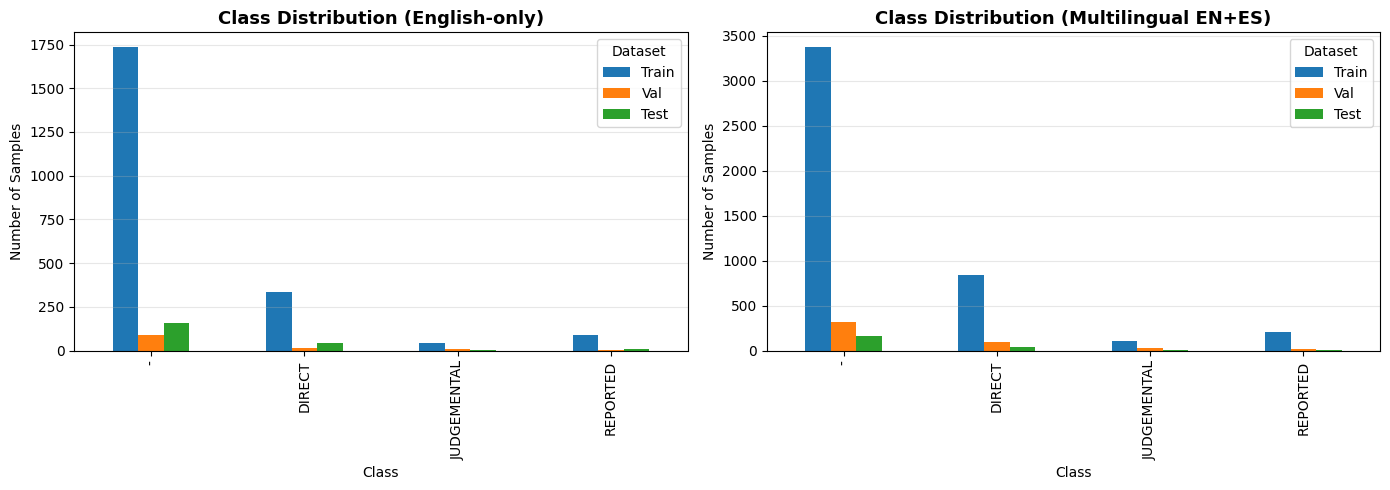


Class Distribution Percentages (English-only):
  -: 73.7%
  DIRECT: 19.4%
  JUDGEMENTAL: 2.3%
  REPORTED: 4.6%

Class Distribution Percentages (Multilingual EN+ES):
  -: 73.7%
  DIRECT: 19.4%
  JUDGEMENTAL: 2.3%
  REPORTED: 4.6%

Dataset Sizes:
  English-only - Train: 2202, Val: 115, Test: 217
  Multilingual (EN+ES) - Train: 4521, Val: 467, Test: 217


In [ ]:
# Class distribution analysis
print("=" * 70)
print("CLASS DISTRIBUTION ANALYSIS - ENGLISH-ONLY")
print("=" * 70)

train_dist = train["label"].value_counts().sort_index()
val_dist = val["label"].value_counts().sort_index()
test_dist = test["label"].value_counts().sort_index()

dist_df = pd.DataFrame(
    {
        "Class": class_names,
        "Train": [train_dist.get(i, 0) for i in range(4)],
        "Val": [val_dist.get(i, 0) for i in range(4)],
        "Test": [test_dist.get(i, 0) for i in range(4)],
    }
)

print(dist_df.to_string(index=False))

# Class distribution for multilingual
print("\n" + "=" * 70)
print("CLASS DISTRIBUTION ANALYSIS - MULTILINGUAL (EN+ES)")
print("=" * 70)

train_dist_multi = train_multi["label"].value_counts().sort_index()
val_dist_multi = val_multi["label"].value_counts().sort_index()
test_dist_multi = test_multi["label"].value_counts().sort_index()

dist_df_multi = pd.DataFrame(
    {
        "Class": class_names,
        "Train": [train_dist_multi.get(i, 0) for i in range(4)],
        "Val": [val_dist_multi.get(i, 0) for i in range(4)],
        "Test": [test_dist_multi.get(i, 0) for i in range(4)],
    }
)

print(dist_df_multi.to_string(index=False))

# Visualize imbalance for both English and Multilingual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# English-only distribution
dist_df.set_index("Class")[["Train", "Val", "Test"]].plot(kind="bar", ax=axes[0])
axes[0].set_title("Class Distribution (English-only)", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Number of Samples")
axes[0].set_xlabel("Class")
axes[0].legend(title="Dataset")
axes[0].grid(True, alpha=0.3, axis="y")

# Multilingual distribution
dist_df_multi.set_index("Class")[["Train", "Val", "Test"]].plot(kind="bar", ax=axes[1])
axes[1].set_title(
    "Class Distribution (Multilingual EN+ES)", fontsize=13, fontweight="bold"
)
axes[1].set_ylabel("Number of Samples")
axes[1].set_xlabel("Class")
axes[1].legend(title="Dataset")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("class_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Check if imbalance affects minority classes
print("\nClass Distribution Percentages (English-only):")
for i, cls in enumerate(class_names):
    test_pct = 100 * test_dist.get(i, 0) / len(test)
    print(f"  {cls}: {test_pct:.1f}%")

print("\nClass Distribution Percentages (Multilingual EN+ES):")
for i, cls in enumerate(class_names):
    test_pct = 100 * test_dist_multi.get(i, 0) / len(test_multi)
    print(f"  {cls}: {test_pct:.1f}%")

print("\nDataset Sizes:")
print(f"  English-only - Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
print(
    f"  Multilingual (EN+ES) - Train: {len(train_multi)}, Val: {len(val_multi)}, Test: {len(test_multi)}"  # noqa: E501
)

OOV (OUT-OF-VOCABULARY) ANALYSIS - ENGLISH-ONLY TEST SET
Samples with high OOV (>5 <UNK> tokens): 18
Samples with low OOV (<=5 <UNK> tokens): 199

----------------------------------------------------------------------
ERROR RATES BY OOV LEVEL
----------------------------------------------------------------------

Baseline LSTM:
  Error rate (high OOV):  11.1%
  Error rate (low OOV):   25.6%
  Difference:             -14.5%

Stacked LSTM:
  Error rate (high OOV):  11.1%
  Error rate (low OOV):   23.1%
  Difference:             -12.0%

Transformer:
  Error rate (high OOV):  5.6%
  Error rate (low OOV):   22.1%
  Difference:             -16.6%

SUMMARY TABLE (ENGLISH-ONLY)
        Model High OOV Error Rate Low OOV Error Rate OOV Impact
Baseline LSTM               11.1%              25.6%     -14.5%
 Stacked LSTM               11.1%              23.1%     -12.0%
  Transformer                5.6%              22.1%     -16.6%


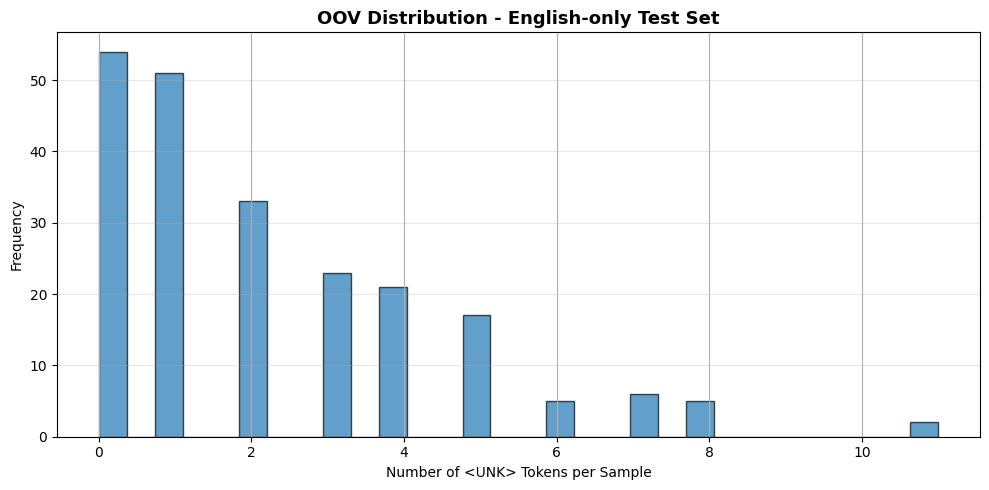


OOV Statistics (English-only):
  Average <UNK> tokens per sample: 2.25
  Max <UNK> tokens in a sample: 11
  Min <UNK> tokens in a sample: 0

MULTILINGUAL MODEL - TOKENIZATION NOTE
The multilingual transformer model uses BERT multilingual tokenizer (subword tokens)
rather than LSTM word-level tokenization, so OOV analysis is not directly comparable.

Transformer Multilingual Error Rate: 22.6%
Transformer English-only Error Rate: 20.7%


In [ ]:
# OOV analysis for all three models
unk_token_idx = vocab["<UNK>"]


def count_unk_in_sample(encoded_indices):
    """Count <UNK> tokens in a sample"""
    return sum(1 for idx in encoded_indices if idx == unk_token_idx)


test["unk_count"] = test["encoded_tweet"].apply(count_unk_in_sample)

# Note: Multilingual model uses transformer tokenizer (subword tokens),
# not LSTM vocabulary. So OOV analysis is not directly comparable

# Generate predictions for all three models on test set if not already done
# Baseline model
base_test_pred = models[42]["baseline_model"].predict(test_padded, verbose=0)
base_test_pred_classes = np.argmax(base_test_pred, axis=1)

# Stacked model
stack_test_pred = models[42]["stacked_model"].predict(test_padded, verbose=0)
stack_test_pred_classes = np.argmax(stack_test_pred, axis=1)

# Transformer (already have this)
# transformer_test_pred_classes is already computed

# Compute error masks for all three models (English-only)
base_errors = y_test != base_test_pred_classes
stack_errors = y_test != stack_test_pred_classes
transformer_errors = y_test != transformer_test_pred_classes

# Multilingual transformer errors
transformer_multi_errors = y_test_multi != transformer_multi_test_pred_classes

# Analyze error rate by OOV (English-only)
high_oov = test["unk_count"] > 5  # noqa: PLR2004
low_oov = test["unk_count"] <= 5  # noqa: PLR2004

print("=" * 70)
print("OOV (OUT-OF-VOCABULARY) ANALYSIS - ENGLISH-ONLY TEST SET")
print("=" * 70)
print(f"Samples with high OOV (>5 <UNK> tokens): {high_oov.sum()}")
print(f"Samples with low OOV (<=5 <UNK> tokens): {low_oov.sum()}")

# Compute error rates for each model
print("\n" + "-" * 70)
print("ERROR RATES BY OOV LEVEL")
print("-" * 70)

models_info = {
    "Baseline LSTM": base_errors,
    "Stacked LSTM": stack_errors,
    "Transformer": transformer_errors,
}

oov_analysis = []

for model_name, error_mask in models_info.items():
    if high_oov.sum() > 0:
        error_rate_high_oov = error_mask[high_oov].sum() / high_oov.sum()
    else:
        error_rate_high_oov = 0

    if low_oov.sum() > 0:
        error_rate_low_oov = error_mask[low_oov].sum() / low_oov.sum()
    else:
        error_rate_low_oov = 0

    diff = error_rate_high_oov - error_rate_low_oov

    print(f"\n{model_name}:")
    print(f"  Error rate (high OOV):  {100 * error_rate_high_oov:.1f}%")
    print(f"  Error rate (low OOV):   {100 * error_rate_low_oov:.1f}%")
    print(f"  Difference:             {100 * diff:.1f}%")

    oov_analysis.append(
        {
            "Model": model_name,
            "High OOV Error Rate": f"{100 * error_rate_high_oov:.1f}%",
            "Low OOV Error Rate": f"{100 * error_rate_low_oov:.1f}%",
            "OOV Impact": f"{100 * diff:.1f}%",
        }
    )

# Summary table
print("\n" + "=" * 70)
print("SUMMARY TABLE (ENGLISH-ONLY)")
print("=" * 70)
oov_summary_df = pd.DataFrame(oov_analysis)
print(oov_summary_df.to_string(index=False))

# Visualize OOV distribution for English-only
fig, ax = plt.subplots(figsize=(10, 5))
test["unk_count"].hist(bins=30, ax=ax, edgecolor="black", alpha=0.7, color="#1f77b4")
ax.set_title("OOV Distribution - English-only Test Set", fontsize=13, fontweight="bold")
ax.set_xlabel("Number of <UNK> Tokens per Sample")
ax.set_ylabel("Frequency")
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig("oov_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\nOOV Statistics (English-only):")
print(f"  Average <UNK> tokens per sample: {test['unk_count'].mean():.2f}")
print(f"  Max <UNK> tokens in a sample: {test['unk_count'].max()}")
print(f"  Min <UNK> tokens in a sample: {test['unk_count'].min()}")

# Multilingual model information
print("\n" + "=" * 70)
print("MULTILINGUAL MODEL - TOKENIZATION NOTE")
print("=" * 70)
print(
    "The multilingual transformer model uses BERT multilingual tokenizer (subword tokens)"  # noqa: E501
)
print(
    "rather than LSTM word-level tokenization, so OOV analysis is not directly comparable."  # noqa: E501
)
print(
    f"\nTransformer Multilingual Error Rate: {(transformer_multi_errors.sum() / len(transformer_multi_errors)) * 100:.1f}%"  # noqa: E501
)
print(
    f"Transformer English-only Error Rate: {(transformer_errors.sum() / len(transformer_errors)) * 100:.1f}%"  # noqa: E501
)

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is **not a copy-paste** of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

## Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions

**Note**: bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Suggestions for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 5 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Expected Results

Task 2 leaderboard reports around 40-50 F1-score.
However, note that they perform a hierarchical classification.

That said, results around 30-40 F1-score are **expected** given the task's complexity.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.


# The End

Feel free to reach out for questions/doubts!